In [ ]:
!nvidia-smi


Tue Nov  4 09:48:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P0             28W /   70W |    2678MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Image Segmentation Experiment

In [ ]:
from pycocotools.cocoeval import COCOeval

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import os
    import torch
    import torchvision
    import sys

    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    os.makedirs("images", exist_ok=True)

    if not os.path.exists("images/truck.jpg"):
        !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    if not os.path.exists("images/groceries.jpg"):
        !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    if not os.path.exists("sam_vit_h_4b8939.pth"):
        !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

    coco_dir = "data/coco"
    if not os.path.exists(coco_dir):
        os.makedirs(coco_dir, exist_ok=True)
        !cd data/coco && wget http://images.cocodataset.org/zips/val2017.zip
        !cd data/coco && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
        !cd data/coco && unzip -q val2017.zip
        !cd data/coco && unzip -q annotations_trainval2017.zip
    else:
        print("COCO dataset directory already exists — skipping download.")


PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0lfjzzza
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0lfjzzza
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-11-04 09:49:03--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg’

truck.jpg           100%[===================>] 265.1

# COCO For Image Segmentation

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import json
from tqdm import tqdm

dataDir = 'data/coco'
dataType = 'val2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'

coco = COCO(annFile)
if 'info' not in coco.dataset:
    coco.dataset['info'] = {
        'description': 'UIIS10K Dataset',
        'version': '1.0',
        'year': 2025,
        'contributor': 'UIIS10K',
        'date_created': '2025/01/01'
    }

if 'licenses' not in coco.dataset:
    coco.dataset['licenses'] = []

print("COCO dataset patched successfully!")

imgIds = coco.getImgIds()
print(len(imgIds))
imgIds = imgIds[:50]

print(f"Loaded {len(imgIds)} images for evaluation")


loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
COCO dataset patched successfully!
5000
Loaded 50 images for evaluation


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import json
from tqdm import tqdm

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

print("SAM model loaded successfully!")


Using device: cuda:0
SAM model loaded successfully!


In [ ]:
def compute_iou(mask1, mask2):
    """Compute Intersection over Union"""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union

def compute_dice(mask1, mask2):
    """Compute Dice Coefficient (F1 Score)"""
    intersection = np.logical_and(mask1, mask2).sum()
    if mask1.sum() + mask2.sum() == 0:
        return 0.0
    return 2 * intersection / (mask1.sum() + mask2.sum())

def compute_precision(mask1, mask2):
    """Compute Precision"""
    true_positive = np.logical_and(mask1, mask2).sum()
    predicted_positive = mask2.sum()
    if predicted_positive == 0:
        return 0.0
    return true_positive / predicted_positive

def compute_recall(mask1, mask2):
    """Compute Recall (Sensitivity)"""
    true_positive = np.logical_and(mask1, mask2).sum()
    actual_positive = mask1.sum()
    if actual_positive == 0:
        return 0.0
    return true_positive / actual_positive

def compute_all_metrics(gt_mask, pred_mask):
    """Compute all segmentation metrics"""
    return {
        'iou': compute_iou(gt_mask, pred_mask),
        'dice': compute_dice(gt_mask, pred_mask),
        'precision': compute_precision(gt_mask, pred_mask),
        'recall': compute_recall(gt_mask, pred_mask)
    }


In [ ]:
from pycocotools.cocoeval import COCOeval

def evaluate_sam_with_ap(predictor, coco, imgIds, prompt_type='box'):
    """
    Evaluate SAM on COCO dataset with AP metrics

    Args:
        predictor: SAM predictor
        coco: COCO API object
        imgIds: List of image IDs to evaluate
        prompt_type: 'box' or 'point'

    Returns:
        results: List of per-annotation metrics
        ious: List of IoU scores
        coco_results: List of results in COCO format for AP computation
    """
    results = []
    ious = []
    coco_results = []

    for imgId in tqdm(imgIds, desc=f"Evaluating with {prompt_type} prompts"):
        img_info = coco.loadImgs(imgId)[0]
        img_path = f"{dataDir}/{dataType}/{img_info['file_name']}"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        predictor.set_image(image)

        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)

        for ann in anns:

            gt_mask = coco.annToMask(ann)

            if prompt_type == 'box':
                bbox = ann['bbox']
                input_box = np.array([
                    bbox[0],
                    bbox[1],
                    bbox[0] + bbox[2],
                    bbox[1] + bbox[3]
                ])

                masks, scores, logits = predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )

            elif prompt_type == 'point':
                bbox = ann['bbox']
                center_x = bbox[0] + bbox[2] / 2
                center_y = bbox[1] + bbox[3] / 2
                input_point = np.array([[center_x, center_y]])
                input_label = np.array([1])

                masks, scores, logits = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    box=None,
                    multimask_output=True,
                )

            pred_mask = masks[0]
            score = float(scores[0])

            iou = compute_iou(gt_mask, pred_mask)
            ious.append(iou)

            results.append({
                'image_id': imgId,
                'annotation_id': ann['id'],
                'category_id': ann['category_id'],
                'iou': iou,
                'area': ann['area']
            })

            pred_mask_rle = maskUtils.encode(np.asfortranarray(pred_mask.astype(np.uint8)))
            pred_mask_rle['counts'] = pred_mask_rle['counts'].decode('utf-8')

            coco_results.append({
                'image_id': imgId,
                'category_id': ann['category_id'],
                'segmentation': pred_mask_rle,
                'score': score
            })

    return results, ious, coco_results


print("Evaluating SAM with bounding box prompts...")
results_box, ious_box, coco_results_box = evaluate_sam_with_ap(
    predictor,
    coco,
    imgIds,
    prompt_type='box'
)

mean_iou_box = np.mean(ious_box)
median_iou_box = np.median(ious_box)
std_iou_box = np.std(ious_box)

print(f"\n=== Results with Box Prompts ===")
print(f"Mean IoU: {mean_iou_box:.4f}")
print(f"Median IoU: {median_iou_box:.4f}")
print(f"Std IoU: {std_iou_box:.4f}")
print(f"Total annotations evaluated: {len(ious_box)}")

if len(coco_results_box) > 0:
    coco_dt = coco.loadRes(coco_results_box)

    coco_eval = COCOeval(coco, coco_dt, iouType='segm')
    coco_eval.params.imgIds = imgIds

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    print("\n=== AP Metrics (Box Prompts) ===")
    print(f"AP @IoU=0.50:0.95: {coco_eval.stats[0]:.4f}")
    print(f"AP @IoU=0.50: {coco_eval.stats[1]:.4f}")
    print(f"AP @IoU=0.75: {coco_eval.stats[2]:.4f}")
    print(f"AP (small): {coco_eval.stats[3]:.4f}")
    print(f"AP (medium): {coco_eval.stats[4]:.4f}")
    print(f"AP (large): {coco_eval.stats[5]:.4f}")

print("\n\nEvaluating SAM with point prompts...")
imgIds2 = imgIds[:]
results_point, ious_point, coco_results_point = evaluate_sam_with_ap(
    predictor,
    coco,
    imgIds2,
    prompt_type='point'
)

mean_iou_point = np.mean(ious_point)
median_iou_point = np.median(ious_point)
std_iou_point = np.std(ious_point)

print(f"\n=== Results with Point Prompts ===")
print(f"Mean IoU: {mean_iou_point:.4f}")
print(f"Median IoU: {median_iou_point:.4f}")
print(f"Std IoU: {std_iou_point:.4f}")

if len(coco_results_point) > 0:
    coco_dt_point = coco.loadRes(coco_results_point)
    coco_eval_point = COCOeval(coco, coco_dt_point, iouType='segm')
    coco_eval_point.params.imgIds = imgIds2

    coco_eval_point.evaluate()
    coco_eval_point.accumulate()
    coco_eval_point.summarize()

    print("\n=== AP Metrics (Point Prompts) ===")
    print(f"AP @IoU=0.50:0.95: {coco_eval_point.stats[0]:.4f}")
    print(f"AP @IoU=0.50: {coco_eval_point.stats[1]:.4f}")
    print(f"AP @IoU=0.75: {coco_eval_point.stats[2]:.4f}")
    print(f"AP (small): {coco_eval_point.stats[3]:.4f}")
    print(f"AP (medium): {coco_eval_point.stats[4]:.4f}")
    print(f"AP (large): {coco_eval_point.stats[5]:.4f}")


Evaluating SAM with bounding box prompts...


Evaluating with box prompts: 100%|██████████| 50/50 [01:40<00:00,  2.00s/it]



=== Results with Box Prompts ===
Mean IoU: 0.7775
Median IoU: 0.8267
Std IoU: 0.1699
Total annotations evaluated: 382
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.654
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ I

Evaluating with point prompts: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]



=== Results with Point Prompts ===
Mean IoU: 0.4420
Median IoU: 0.4715
Std IoU: 0.3139
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | ma

# UIIS (Underwater Image Segmentation)

In [ ]:
!git clone https://huggingface.co/datasets/LiamLian0727/UIIS uiis_dataset

Cloning into 'uiis_dataset'...
remote: Enumerating objects: 4652, done.
remote: Total 4652 (delta 0), reused 0 (delta 0), pack-reused 4652 (from 1)
Receiving objects: 100% (4652/4652), 660.47 KiB | 2.75 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (4632/4632), done.
Filtering content: 100% (4630/4630), 603.50 MiB | 29.70 MiB/s, done.


In [ ]:
UIIS_CLASSES = {
    1: 'fish',
    2: 'reefs',
    3: 'aquatic plants',
    4: 'wrecks/ruins',
    5: 'human divers',
    6: 'robots',
    7: 'sea-floor'
}


dataDir = 'uiis_dataset'
annFile = f'{dataDir}/annotations/val.json'

coco = COCO(annFile)
imgIds = coco.getImgIds()

print(f"Loaded {len(imgIds)} images from UIIS10K")
print(f"Classes: {UIIS_CLASSES}")


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
Loaded 691 images from UIIS10K
Classes: {1: 'fish', 2: 'reefs', 3: 'aquatic plants', 4: 'wrecks/ruins', 5: 'human divers', 6: 'robots', 7: 'sea-floor'}


In [ ]:
def evaluate_sam_per_class(predictor, coco, imgIds, class_names, prompt_type='box'):
    sample_visualizations = []

    """
    Detailed per-class evaluation

    Returns:
        per_class_results: Dict with detailed metrics per class
        all_results: List of all individual predictions
    """

    per_class_metrics = {class_id: {
        'ious': [],
        'dices': [],
        'precisions': [],
        'recalls': [],
        'count': 0,
        'area_small': {'iou': [], 'dice': []},
        'area_medium': {'iou': [], 'dice': []},
        'area_large': {'iou': [], 'dice': []},
        'occlusion_light': [],
        'occlusion_heavy': []
    } for class_id in class_names.keys()}

    all_results = []
    coco_results = []
    processed_count = 0

    for imgId in tqdm(imgIds, desc=f"Evaluating with {prompt_type} prompts"):
        img_info = coco.loadImgs(imgId)
        if not img_info:
            continue

        img_info = img_info[0]
        img_path = f"{dataDir}/val/{img_info['file_name']}"

        if not os.path.exists(img_path):
            print("path does not exist " + img_path)
            continue

        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predictor.set_image(image)

        annIds = coco.getAnnIds(imgIds=imgId)
        print("annIds")
        print(annIds)
        anns = coco.loadAnns(annIds)
        print(anns)

        for ann in anns:
            category_id = ann['category_id']

            if category_id not in class_names:
                print(category_id + " not in class name " + class_names)
                continue

            gt_mask = coco.annToMask(ann)

            area = ann['area']
            if area < 1024:
                size_category = 'small'
            elif area < 9216:
                size_category = 'medium'
            else:
                size_category = 'large'

            try:
                if prompt_type == 'box':
                    bbox = ann['bbox']
                    input_box = np.array([
                        bbox[0], bbox[1],
                        bbox[0] + bbox[2], bbox[1] + bbox[3]
                    ])

                    masks, scores, logits = predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )

                elif prompt_type == 'point':
                    bbox = ann['bbox']
                    center_x = bbox[0] + bbox[2] / 2
                    center_y = bbox[1] + bbox[3] / 2
                    input_point = np.array([[center_x, center_y]])
                    input_label = np.array([1])

                    masks, scores, logits = predictor.predict(
                        point_coords=input_point,
                        point_labels=input_label,
                        box=None,
                        multimask_output=True,
                    )
                    masks = masks[np.argmax(scores)][None, ...]

                pred_mask = masks[0]
                score = float(scores[0])

                metrics = compute_all_metrics(gt_mask, pred_mask)

                per_class_metrics[category_id]['ious'].append(metrics['iou'])
                per_class_metrics[category_id]['dices'].append(metrics['dice'])
                per_class_metrics[category_id]['precisions'].append(metrics['precision'])
                per_class_metrics[category_id]['recalls'].append(metrics['recall'])
                per_class_metrics[category_id]['count'] += 1
                per_class_metrics[category_id][f'area_{size_category}']['iou'].append(metrics['iou'])
                per_class_metrics[category_id][f'area_{size_category}']['dice'].append(metrics['dice'])

                cat_name = coco.loadCats(category_id)[0]['name']

                result = {
                    'image_id': imgId,
                    'annotation_id': ann.get('id', processed_count),
                    'category_id': category_id,
                    'category_name': cat_name,
                    'iou': metrics['iou'],
                    'dice': metrics['dice'],
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'area': area,
                    'size_category': size_category
                }

                all_results.append(result)
                pred_mask_rle = maskUtils.encode(np.asfortranarray(pred_mask.astype(np.uint8)))
                pred_mask_rle['counts'] = pred_mask_rle['counts'].decode('utf-8')

                coco_results.append({
                'image_id': int(imgId),
                'category_id': int(category_id),
                'segmentation': pred_mask_rle,
                'score': float(score)
                })
                if len([s for s in sample_visualizations if s['category_id'] == category_id]) < 5:
                    sample_visualizations.append({
                        'image': image.copy(),
                        'gt_mask': gt_mask,
                        'pred_mask': pred_mask,
                        'metrics': metrics,
                        'category_id': category_id,
                        'category_name': cat_name,
                        'bbox': bbox
                    })

                processed_count += 1

            except Exception as e:
                print(f"Error processing annotation {ann['id']}: {e}")
                continue

    return per_class_metrics, all_results, sample_visualizations, coco_results


In [ ]:
from pycocotools.cocoeval import COCOeval
import json

print("Evaluating SAM on UIIS dataset with box prompts...")

per_class_metrics_box, all_results_box, samples_box, coco_results_box = evaluate_sam_per_class(
    predictor, coco, imgIds[:50], UIIS_CLASSES, prompt_type='box'
)

per_class_metrics_point, all_results_point, samples_point, coco_results_point = evaluate_sam_per_class(
    predictor, coco, imgIds[:50], UIIS_CLASSES, prompt_type='point'
)

print("\n=== Per-Class Results (Box Prompts) ===")
for class_id, metrics in per_class_metrics_box.items():
    if metrics['count'] > 0:
        cat_name = coco.loadCats(class_id)[0]['name']
        mean_iou = np.mean(metrics['ious'])
        mean_dice = np.mean(metrics['dices'])
        mean_precision = np.mean(metrics['precisions'])
        mean_recall = np.mean(metrics['recalls'])

        print(f"\n{cat_name} (n={metrics['count']}):")
        print(f"  Mean IoU: {mean_iou:.4f}")
        print(f"  Mean Dice: {mean_dice:.4f}")
        print(f"  Mean Precision: {mean_precision:.4f}")
        print(f"  Mean Recall: {mean_recall:.4f}")

        for size in ['small', 'medium', 'large']:
            if len(metrics[f'area_{size}']['iou']) > 0:
                size_iou = np.mean(metrics[f'area_{size}']['iou'])
                print(f"  {size.capitalize()} objects IoU: {size_iou:.4f} (n={len(metrics[f'area_{size}']['iou'])})")

all_ious_box = [r['iou'] for r in all_results_box]
all_dices_box = [r['dice'] for r in all_results_box]

print(f"\n=== Overall Metrics (Box Prompts) ===")
print(f"Mean IoU: {np.mean(all_ious_box):.4f}")
print(f"Median IoU: {np.median(all_ious_box):.4f}")
print(f"Mean Dice: {np.mean(all_dices_box):.4f}")
print(f"Total annotations: {len(all_results_box)}")

if len(coco_results_box) > 0:
    print("\n=== Computing AP Metrics (Box Prompts) ===")
    if 'info' not in coco.dataset:
        coco.dataset['info'] = {
            'description': 'UIIS Dataset',
            'version': '1.0',
            'year': 2025,
            'contributor': '',
            'date_created': '2025/01/01'
        }
    coco_dt = coco.loadRes(coco_results_box)

    coco_eval = COCOeval(coco, coco_dt, iouType='segm')
    coco_eval.params.imgIds = [int(r['image_id']) for r in coco_results_box]

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    print("\n=== AP Metrics Summary ===")
    print(f"AP @IoU=0.50:0.95 (all areas): {coco_eval.stats[0]:.4f}")
    print(f"AP @IoU=0.50: {coco_eval.stats[1]:.4f}")
    print(f"AP @IoU=0.75: {coco_eval.stats[2]:.4f}")
    print(f"AP (small objects): {coco_eval.stats[3]:.4f}")
    print(f"AP (medium objects): {coco_eval.stats[4]:.4f}")
    print(f"AP (large objects): {coco_eval.stats[5]:.4f}")



Evaluating SAM on UIIS dataset with box prompts...


Evaluating with box prompts:   2%|▏         | 1/50 [00:02<01:43,  2.11s/it]

annIds
[1, 2, 3, 4, 5, 6, 7, 8]
[{'segmentation': [[64.85081292774565, 64.24661300202087, 69.73513169381248, 65.27489063698226, 72.30582578121609, 67.58851531564554, 76.16186691232149, 67.58851531564554, 82.5, 69.0, 85.2, 64.1, 87.5, 64.0, 89.01533734933948, 61.67591891461726, 86.4446432619359, 60.1335024621751, 84.6, 59.5, 83.7, 55.6, 80.1, 55.0, 75.5, 56.0, 71.7, 57.5, 69.47806228507214, 59.87643305343474]], 'iscrowd': 0, 'area': 196.48198656452587, 'image_id': 0, 'bbox': [64.0, 55.0, 25.0, 14.0], 'category_id': 1, 'id': 1}, {'segmentation': [[68.33161953727506, 147.74545787775457, 67.81748071979433, 150.83029078263888, 68.58868894601542, 154.94340132248465, 70.6452442159383, 155.97167895744607, 70.90231362467867, 159.0565118623304, 71.9305912596401, 162.39841417595508, 72.18766066838046, 164.71203885461833, 70.38817480719794, 168.56807998572373, 69.87403598971721, 171.1387740731273, 70.13110539845758, 172.68119052556946, 70.90231362467867, 176.53723165667486, 72.44473007712082, 180.

Evaluating with box prompts:   4%|▍         | 2/50 [00:04<01:38,  2.06s/it]

annIds
[9]
[{'segmentation': [[85.55526992287918, 101.79948586118252, 88.12596401028276, 115.16709511568124, 88.12596401028276, 121.8508997429306, 85.29820051413881, 129.82005141388174, 83.24164524421593, 136.24678663239075, 79.6426735218509, 143.7017994858612, 73.73007712082261, 152.4421593830334, 70.6452442159383, 160.41131105398458, 67.56041131105397, 168.12339331619538, 65.50385604113109, 170.69408740359896, 66.53213367609254, 177.12082262210797, 67.81748071979433, 182.51928020565552, 70.90231362467867, 187.6606683804627, 74.75835475578407, 190.48843187660668, 79.38560411311053, 187.91773778920307, 84.78406169665809, 184.31876606683804, 92.75321336760925, 180.46272493573264, 100.46529562982005, 176.60668380462724, 107.66323907455012, 169.66580976863753, 112.03341902313625, 165.80976863753213, 116.66066838046271, 158.86889460154242, 119.23136246786632, 154.4987146529563, 122.05912596401026, 150.38560411311053, 124.62982005141387, 147.04370179948586, 129.51413881748073, 141.902313624

Evaluating with box prompts:   6%|▌         | 3/50 [00:06<01:37,  2.07s/it]

annIds
[10, 11, 12, 13, 14]
[{'segmentation': [[198.40874035989714, 2.570694087403599, 195.32390745501283, 9.768637532133676, 191.21079691516707, 16.709511568123393, 190.95372750642673, 21.33676092544987, 193.01028277634958, 28.020565552699228, 193.26735218508998, 31.105398457583547, 191.46786632390746, 34.96143958868895, 194.29562982005143, 44.473007712082264, 191.46786632390746, 50.38560411311054, 187.61182519280203, 54.75578406169666, 189.1542416452442, 62.98200514138817, 184.26992287917736, 68.38046272493573, 183.75578406169666, 71.46529562982005, 184.78406169665809, 78.92030848329048, 175.27249357326477, 84.83290488431876, 171.9305912596401, 87.146529562982, 170.13110539845758, 95.62982005141387, 167.3033419023136, 99.48586118251927, 165.76092544987145, 104.11311053984575, 165.5038560411311, 107.96915167095115, 166.01799485861181, 114.91002570694087, 170.13110539845758, 116.70951156812339, 172.95886889460152, 116.96658097686375, 176.30077120822622, 113.88174807197943, 181.69922879

Evaluating with box prompts:   8%|▊         | 4/50 [00:08<01:34,  2.06s/it]

annIds
[15]
[{'segmentation': [[85.04113110539845, 116.45244215938303, 86.84061696658097, 124.9357326478149, 88.12596401028276, 131.3624678663239, 92.23907455012852, 137.53213367609254, 94.2956298200514, 141.6452442159383, 101.23650385604114, 143.7017994858612, 108.69151670951157, 146.52956298200513, 114.60411311053983, 149.3573264781491, 118.20308483290489, 151.413881748072, 125.91516709511566, 156.04113110539845, 132.0848329048843, 157.5835475578406, 137.74035989717223, 157.32647814910024, 144.16709511568124, 157.5835475578406, 146.99485861182518, 155.01285347043702, 146.73778920308482, 151.67095115681232, 146.73778920308482, 148.586118251928, 147.25192802056554, 146.27249357326477, 147.5089974293059, 142.9305912596401, 147.5089974293059, 137.27506426735218, 148.280205655527, 133.16195372750641, 148.280205655527, 130.8483290488432, 146.73778920308482, 126.99228791773778, 146.73778920308482, 124.42159383033419, 145.45244215938303, 117.48071979434447, 142.11053984575835, 114.3958868894

Evaluating with box prompts:  10%|█         | 5/50 [00:10<01:32,  2.06s/it]

annIds
[16]
[{'segmentation': [[115.16867469879517, 71.56626506024095, 118.78313253012047, 74.4578313253012, 123.6024096385542, 78.79518072289156, 127.45783132530119, 82.16867469879517, 130.34939759036143, 84.81927710843372, 135.65060240963854, 88.9156626506024, 146.25301204819274, 95.90361445783132, 153.96385542168673, 98.79518072289156, 160.95180722891564, 100.48192771084337, 168.66265060240963, 103.6144578313253, 176.37349397590359, 104.57831325301204, 177.33734939759034, 104.57831325301204, 183.1204819277108, 106.50602409638553, 190.59036144578312, 107.95180722891565, 198.0602409638554, 109.15662650602408, 205.77108433734938, 110.36144578313252, 215.89156626506022, 112.5301204819277, 220.46987951807228, 112.5301204819277, 223.1204819277108, 118.0722891566265, 232.75903614457832, 123.6144578313253, 237.8192771084337, 126.98795180722891, 241.91566265060237, 122.65060240963854, 245.53012048192767, 118.55421686746988, 251.07228915662648, 113.01204819277108, 253.0, 109.87951807228914, 2

Evaluating with box prompts:  12%|█▏        | 6/50 [00:12<01:31,  2.08s/it]

annIds
[17, 18, 19, 20, 21]
[{'segmentation': [[30.570694087403595, 55.26992287917738, 35.7120822622108, 55.526992287917736, 39.311053984575835, 55.26992287917738, 44.452442159383025, 55.26992287917738, 50.62210796915167, 55.526992287917736, 55.24935732647815, 56.041131105398456, 58.077120822622106, 56.041131105398456, 61.933161953727506, 55.78406169665809, 65.7892030848329, 57.0694087403599, 67.84575835475579, 54.498714652956295, 70.9305912596401, 51.9280205655527, 73.75835475578407, 49.3573264781491, 75.30077120822622, 43.70179948586118, 73.75835475578407, 41.90231362467866, 69.13110539845758, 40.102827763496144, 62.70437017994857, 36.246786632390744, 60.90488431876605, 34.70437017994858, 60.39074550128535, 28.79177377892031, 63.47557840616966, 26.22107969151671, 66.04627249357327, 21.59383033419023, 65.27506426735218, 14.910025706940873, 57.305912596401015, 14.652956298200513, 55.76349614395886, 14.652956298200513, 55.24935732647815, 11.311053984575835, 46.76606683804627, 10.2827763

Evaluating with box prompts:  14%|█▍        | 7/50 [00:14<01:29,  2.09s/it]

annIds
[22]
[{'segmentation': [[60.39074550128535, 121.33676092544987, 56.27763496143959, 129.56298200514138, 54.73521850899742, 135.73264781491002, 52.9357326478149, 144.47300771208225, 53.192802056555266, 155.78406169665809, 53.96401028277634, 169.1516709511568, 54.47814910025707, 177.89203084832906, 57.56298200514138, 184.83290488431876, 60.39074550128535, 190.48843187660668, 57.82005141388174, 201.54241645244215, 56.53470437017995, 208.2262210796915, 54.992287917737784, 214.91002570694087, 54.22107969151671, 220.05141388174806, 55.50642673521851, 225.19280205655525, 60.90488431876605, 231.61953727506426, 61.933161953727506, 235.9897172236504, 62.44730077120823, 241.6452442159383, 62.70437017994857, 245.75835475578404, 65.53213367609254, 253.47043701799484, 67.0, 255.0, 254.0, 255.0, 255.0, 254.0, 255.0, 226.0, 255.0, 188.0, 255.0, 129.0, 255.0, 57.0, 255.0, 18.0, 255.0, 1.0, 113.86118251928019, 0.5141388174807198, 109.23393316195373, 2.313624678663239, 101.52185089974293, 3.5989717

Evaluating with box prompts:  16%|█▌        | 8/50 [00:16<01:28,  2.10s/it]

annIds
[23, 24]
[{'segmentation': [[79.74698795180721, 113.73493975903614, 84.56626506024095, 112.7710843373494, 88.66265060240963, 111.32530120481927, 91.31325301204818, 109.87951807228914, 98.78313253012047, 107.71084337349397, 100.95180722891565, 106.26506024096385, 107.45783132530119, 104.09638554216866, 117.57831325301203, 104.09638554216866, 120.71084337349396, 104.57831325301204, 121.19277108433732, 105.78313253012047, 120.46987951807228, 108.19277108433734, 117.81927710843371, 109.63855421686746, 114.92771084337349, 111.80722891566263, 112.03614457831324, 114.93975903614457, 106.49397590361446, 118.55421686746988, 100.22891566265059, 122.40963855421685, 94.68674698795179, 125.54216867469879, 86.25301204819276, 130.36144578313252, 74.20481927710843, 133.73493975903614, 85.04819277108433, 131.32530120481925, 99.26506024096385, 125.3012048192771, 110.8313253012048, 119.27710843373492, 118.3012048192771, 115.42168674698794, 111.07228915662648, 121.92771084337349, 97.09638554216866,

Evaluating with box prompts:  18%|█▊        | 9/50 [00:18<01:26,  2.11s/it]

annIds
[25, 26]
[{'segmentation': [[112.31325301204818, 149.15662650602408, 117.6144578313253, 160.24096385542168, 122.67469879518072, 171.08433734939757, 125.56626506024097, 178.79518072289156, 128.2168674698795, 186.26506024096383, 133.7590361445783, 200.72289156626505, 134.72289156626505, 204.57831325301203, 134.72289156626505, 211.08433734939757, 137.1325301204819, 217.8313253012048, 148.45783132530119, 222.16867469879517, 158.57831325301203, 223.1325301204819, 167.49397590361446, 224.09638554216866, 176.89156626506022, 221.92771084337346, 185.80722891566265, 220.96385542168673, 191.10843373493975, 218.07228915662648, 199.3012048192771, 214.93975903614455, 204.8433734939759, 212.04819277108433, 211.59036144578312, 210.36144578313252, 214.24096385542165, 209.63855421686745, 212.55421686746985, 204.33734939759034, 206.5301204819277, 199.5180722891566, 198.33734939759034, 197.59036144578312, 191.34939759036143, 196.38554216867468, 183.63855421686745, 193.49397590361446, 175.9277108433

Evaluating with box prompts:  20%|██        | 10/50 [00:20<01:25,  2.13s/it]

annIds
[27, 28, 29, 30, 31]
[{'segmentation': [[64.91002570694087, 84.5758354755784, 67.9948586118252, 84.83290488431876, 72.10796915167094, 87.146529562982, 80.33419023136247, 86.88946015424165, 86.76092544987145, 84.06169665809769, 92.159383033419, 82.0051413881748, 94.47300771208225, 77.6349614395887, 95.24421593830334, 74.55012853470437, 96.27249357326477, 71.46529562982005, 99.61439588688947, 72.75064267352185, 102.44215938303341, 70.95115681233933, 103.98457583547557, 63.753213367609256, 103.7275064267352, 58.09768637532134, 97.55784061696659, 60.411311053984576, 96.7866323907455, 60.66838046272493, 95.5012853470437, 58.354755784061695, 93.70179948586119, 55.012853470437015, 88.04627249357327, 53.2133676092545, 79.82005141388174, 54.75578406169666, 75.44987146529563, 57.840616966580974, 70.56555269922879, 62.46786632390745, 69.28020565552698, 64.78149100257069, 66.19537275064268, 71.20822622107968, 66.45244215938303, 74.80719794344473, 65.68123393316195, 77.89203084832904, 62.596

Evaluating with box prompts:  22%|██▏       | 11/50 [00:23<01:23,  2.14s/it]

annIds
[32, 33]
[{'segmentation': [[3.2133676092544974, 161.439588688946, 8.097686375321338, 159.64010282776349, 14.78149100257069, 158.86889460154242, 15.80976863753213, 156.2982005141388, 22.236503856041125, 150.89974293059126, 26.606683804627252, 149.8714652956298, 29.177377892030847, 147.5578406169666, 26.092544987146525, 147.30077120822622, 24.55012853470437, 146.0154241645244, 23.007712082262202, 144.7300771208226, 22.49357326478149, 143.7017994858612, 23.52185089974293, 139.58868894601542, 24.807197943444734, 138.30334190231363, 23.264781491002566, 135.2185089974293, 26.34961439588689, 133.41902313624678, 28.40616966580977, 131.3624678663239, 30.976863753213365, 128.2776349614396, 32.77634961439588, 126.2210796915167, 37.40359897172236, 124.42159383033419, 42.544987146529564, 123.13624678663238, 47.17223650385604, 123.65038560411311, 52.05655526992288, 123.13624678663238, 57.455012853470436, 123.90745501285346, 65.16709511568124, 124.42159383033419, 69.28020565552698, 127.249357

Evaluating with box prompts:  26%|██▌       | 13/50 [00:27<01:21,  2.22s/it]

annIds
[40]
[{'segmentation': [[98.07197943444729, 110.79691516709511, 91.13110539845758, 118.50899742930591, 88.30334190231363, 123.13624678663238, 83.67609254498714, 128.53470437017995, 79.82005141388174, 134.19023136246787, 76.47814910025707, 140.10282776349615, 72.3650385604113, 146.7866323907455, 67.73778920308483, 155.2699228791774, 64.1388174807198, 161.18251928020564, 58.740359897172226, 171.20822622107968, 51.28534704370179, 178.92030848329048, 45.88688946015424, 183.8046272493573, 40.48843187660668, 187.40359897172235, 34.832904884318765, 190.48843187660668, 32.51928020565552, 191.5167095115681, 30.719794344473, 192.80205655526993, 27.37789203084833, 193.83033419023135, 25.321336760925448, 191.5167095115681, 21.208226221079684, 192.2879177377892, 20.69408740359897, 198.97172236503854, 23.52185089974293, 204.62724935732646, 28.920308483290484, 204.62724935732646, 32.51928020565552, 202.82776349614394, 38.17480719794344, 201.02827763496143, 42.03084832904884, 198.71465295629818

Evaluating with box prompts:  28%|██▊       | 14/50 [00:29<01:19,  2.21s/it]

annIds
[41, 42]
[{'segmentation': [[62.85347043701799, 107.19794344473007, 69.53727506426735, 115.93830334190231, 73.65038560411311, 121.59383033419023, 66.70951156812339, 118.50899742930591, 62.339331619537276, 116.96658097686375, 57.455012853470436, 114.91002570694087, 52.82776349614396, 113.11053984575835, 42.03084832904884, 107.7120822622108, 45.37275064267352, 112.85347043701799, 51.79948586118252, 119.53727506426735, 58.99742930591259, 123.39331619537275, 63.62467866323907, 126.73521850899742, 67.2236503856041, 128.79177377892032, 58.99742930591259, 128.02056555269922, 52.05655526992288, 130.0771208226221, 46.658097686375314, 130.0771208226221, 31.23393316195373, 130.59125964010283, 31.23393316195373, 131.87660668380462, 30.976863753213365, 135.2185089974293, 33.804627249357324, 139.8457583547558, 43.31619537275064, 144.2159383033419, 41.002570694087396, 144.98714652956298, 34.5758354755784, 145.75835475578407, 27.892030848329043, 144.2159383033419, 30.976863753213365, 148.071979

Evaluating with box prompts:  30%|███       | 15/50 [00:32<01:17,  2.21s/it]

annIds
[43]
[{'segmentation': [[16.580976863753207, 80.20565552699229, 24.55012853470437, 86.63239074550128, 21.979434447300775, 89.7172236503856, 12.210796915167094, 92.2879177377892, 11.43958868894601, 95.62982005141387, 18.894601542416453, 94.60154241645245, 22.750642673521853, 97.4293059125964, 28.920308483290484, 96.65809768637531, 24.035989717223643, 99.74293059125964, 8.097686375321338, 103.08483290488431, 3.9845758354755745, 105.14138817480719, 16.323907455012858, 105.91259640102827, 5.784061696658092, 108.74035989717223, 20.437017994858607, 107.19794344473007, 27.634961439588693, 107.45501285347044, 0.0, 111.0, 0.0, 117.0, 3.727506426735218, 117.73778920308483, 16.066838046272494, 115.68123393316195, 19.66580976863753, 115.68123393316195, 15.295629820051417, 118.25192802056554, 18.63753213367609, 119.28020565552698, 19.922879177377894, 122.3650385604113, 19.151670951156817, 126.73521850899742, 20.69408740359897, 128.53470437017995, 26.34961439588689, 122.3650385604113, 29.4344

Evaluating with box prompts:  32%|███▏      | 16/50 [00:34<01:15,  2.22s/it]

annIds
[44, 45, 46, 47, 48, 49]
[{'segmentation': [[73.90745501285346, 47.04370179948586, 69.02313624678663, 49.61439588688946, 63.62467866323907, 52.18508997429306, 56.68380462724936, 64.01028277634961, 54.62724935732648, 74.03598971722364, 50.77120822622108, 88.4318766066838, 50.257069408740364, 101.54241645244215, 46.658097686375314, 103.08483290488431, 45.62982005141387, 107.19794344473007, 49.48586118251927, 111.31105398457584, 50.0, 117.48071979434447, 52.31362467866323, 121.33676092544987, 46.401028277634964, 131.61953727506426, 46.1439588688946, 136.24678663239075, 50.51413881748071, 128.79177377892032, 54.11311053984575, 125.70694087403598, 60.53984575835476, 128.02056555269922, 68.76606683804627, 130.33419023136247, 79.04884318766065, 133.41902313624678, 87.27506426735218, 134.70437017994857, 84.44730077120823, 131.61953727506426, 78.53470437017995, 127.50642673521851, 74.9357326478149, 124.42159383033419, 71.0796915167095, 118.76606683804627, 70.05141388174806, 110.796915167

Evaluating with box prompts:  34%|███▍      | 17/50 [00:36<01:12,  2.21s/it]

annIds
[50]
[{'segmentation': [[1.710843373493975, 71.08433734939759, 7.734939759036143, 69.1566265060241, 12.31325301204819, 68.9156626506024, 19.78313253012048, 69.1566265060241, 24.8433734939759, 72.04819277108433, 29.180722891566262, 73.01204819277108, 34.0, 72.7710843373494, 36.40963855421686, 71.32530120481927, 37.855421686746986, 66.98795180722891, 39.3012048192771, 64.33734939759036, 44.361445783132524, 62.16867469879517, 46.77108433734939, 63.614457831325296, 49.18072289156626, 61.20481927710843, 55.92771084337349, 57.10843373493975, 64.36144578313252, 53.73493975903614, 71.59036144578313, 52.28915662650602, 86.04819277108433, 53.253012048192765, 97.85542168674698, 53.253012048192765, 108.93975903614457, 53.97590361445783, 118.33734939759034, 54.69879518072289, 125.56626506024097, 55.18072289156626, 131.8313253012048, 55.18072289156626, 137.3734939759036, 54.21686746987951, 144.6024096385542, 52.77108433734939, 153.03614457831324, 50.843373493975896, 160.02409638554215, 49.397

Evaluating with box prompts:  38%|███▊      | 19/50 [00:41<01:09,  2.25s/it]

annIds
[60, 61]
[{'segmentation': [[61.568123393316185, 183.2904884318766, 64.91002570694087, 186.11825192802056, 72.3650385604113, 186.11825192802056, 82.64781491002572, 186.11825192802056, 89.33161953727506, 184.06169665809767, 98.32904884318765, 179.4344473007712, 104.75578406169666, 174.293059125964, 112.46786632390746, 168.89460154241644, 115.03856041131104, 161.439588688946, 120.95115681233932, 153.98457583547557, 122.23650385604114, 147.04370179948586, 127.37789203084833, 142.159383033419, 132.51928020565552, 136.24678663239075, 138.68894601542416, 128.79177377892032, 143.31619537275063, 121.8508997429306, 147.17223650385603, 116.19537275064268, 151.02827763496143, 110.53984575835476, 153.0848329048843, 106.16966580976863, 157.45501285347044, 101.79948586118252, 160.7969151670951, 97.68637532133675, 162.33933161953726, 93.573264781491, 165.68123393316193, 86.63239074550128, 162.59640102827763, 84.83290488431876, 167.99485861182518, 78.40616966580977, 165.16709511568124, 76.60668

Evaluating with box prompts:  42%|████▏     | 21/50 [00:45<01:05,  2.27s/it]

annIds
[72, 73, 74, 75, 76, 77, 78]
[{'segmentation': [[0.29154518950437314, 203.2069970845481, 9.315789473684205, 193.42105263157893, 17.73684210526315, 195.52631578947367, 27.473684210526315, 189.73684210526315, 30.105263157894726, 186.57894736842104, 35.63157894736841, 181.8421052631579, 43.78947368421052, 190.78947368421052, 39.315789473684205, 197.6315789473684, 31.68421052631578, 201.3157894736842, 43.263157894736835, 210.78947368421052, 45.89473684210526, 209.73684210526315, 47.473684210526315, 211.8421052631579, 51.94736842105263, 214.99999999999997, 56.421052631578945, 221.8421052631579, 56.157894736842096, 222.36842105263156, 61.68421052631578, 226.57894736842104, 54.315789473684205, 232.6315789473684, 71.68421052631578, 228.42105263157893, 79.05263157894736, 215.26315789473682, 88.0, 214.4736842105263, 90.10526315789474, 202.6315789473684, 88.52631578947367, 195.0, 83.52631578947367, 192.1052631578947, 83.78947368421052, 181.3157894736842, 75.63157894736841, 172.105263157894

Evaluating with box prompts:  44%|████▍     | 22/50 [00:47<01:02,  2.22s/it]

annIds
[79]
[{'segmentation': [[118.70967741935483, 61.483870967741936, 114.51612903225806, 68.25806451612902, 113.2258064516129, 71.80645161290322, 108.13743218806509, 71.60940325497288, 102.16998191681735, 71.42857142857143, 95.84086799276672, 71.42857142857143, 88.06509945750452, 71.06690777576853, 80.28933092224231, 70.88607594936708, 71.24773960216997, 69.98191681735985, 63.833634719710666, 69.25858951175407, 55.87703435804701, 67.8119349005425, 47.55877034358047, 66.36528028933093, 39.059674502712475, 63.65280289330922, 32.36889692585895, 62.386980108499095, 25.31645569620253, 60.94032549728752, 19.34900542495479, 60.39783001808318, 14.64737793851718, 60.39783001808318, 11.934900542495479, 61.12115732368897, 11.211573236889691, 63.291139240506325, 13.5623869801085, 67.8119349005425, 16.998191681735985, 72.875226039783, 20.61482820976492, 78.66184448462928, 23.869801084990957, 83.00180831826401, 25.678119349005424, 87.16094032549728, 29.475587703435803, 94.03254972875226, 31.46473

Evaluating with box prompts:  46%|████▌     | 23/50 [00:50<00:59,  2.19s/it]

annIds
[80]
[{'segmentation': [[226.24113475177302, 127.89598108747043, 227.42316784869973, 130.61465721040187, 228.13238770685578, 132.9787234042553, 229.1962174940898, 135.34278959810874, 229.6690307328605, 137.35224586288416, 230.14184397163118, 139.5981087470449, 230.37825059101652, 141.96217494089834, 230.85106382978722, 144.91725768321513, 231.6784869976359, 148.10874704491724, 232.26950354609926, 150.94562647754137, 233.45153664302597, 154.13711583924348, 235.22458628841605, 155.91016548463355, 236.52482269503543, 158.15602836879432, 238.17966903073284, 161.1111111111111, 239.71631205673756, 164.53900709219857, 240.07092198581557, 166.31205673758865, 240.18912529550826, 168.9125295508274, 238.53427895981085, 171.15839243498817, 236.6430260047281, 173.52245862884158, 234.16075650118202, 175.886524822695, 231.44208037825058, 178.8416075650118, 229.07801418439715, 180.02364066193851, 226.83215130023638, 182.1513002364066, 223.87706855791959, 184.6335697399527, 221.27659574468083, 1

Evaluating with box prompts:  48%|████▊     | 24/50 [00:52<00:56,  2.17s/it]

annIds
[81]
[{'segmentation': [[184.5, 141.6, 182.4736842105263, 146.57894736842104, 183.52631578947367, 152.10526315789474, 192.4736842105263, 164.4736842105263, 198.52631578947367, 176.05263157894737, 194.1, 186.8, 190.36842105263156, 188.94736842105263, 184.8421052631579, 190.0, 179.3157894736842, 186.05263157894734, 173.1, 180.5, 167.99999999999997, 173.68421052631578, 162.73684210526315, 168.68421052631578, 154.57894736842104, 161.8421052631579, 147.73684210526315, 157.89473684210526, 140.8, 155.6, 131.68421052631578, 154.4736842105263, 123.0, 156.8421052631579, 113.52631578947367, 162.36842105263156, 105.4, 167.7, 97.8, 172.3, 89.0, 176.3, 82.4, 179.3, 76.5, 176.3, 74.0, 179.3, 68.8, 183.9, 61.9, 182.3, 58.263157894736835, 175.26315789473682, 54.7, 171.0, 59.9, 165.9, 62.8, 163.4, 64.57894736842104, 154.21052631578945, 70.89473684210526, 159.21052631578945, 72.4736842105263, 157.36842105263156, 74.57894736842104, 148.68421052631578, 74.84210526315789, 147.89473684210526, 81.68421

Evaluating with box prompts:  50%|█████     | 25/50 [00:54<00:53,  2.15s/it]

annIds
[82, 83]
[{'segmentation': [[103.57303370786516, 141.85393258426967, 104.41573033707866, 136.79775280898878, 106.6629213483146, 130.61797752808988, 108.34831460674158, 126.96629213483146, 108.34831460674158, 123.31460674157303, 111.15730337078651, 120.78651685393258, 115.08988764044943, 113.48314606741573, 119.58426966292134, 109.26966292134831, 123.51685393258427, 107.58426966292134, 129.13483146067415, 106.46067415730337, 132.22471910112358, 103.37078651685393, 136.7191011235955, 103.08988764044943, 138.68539325842696, 100.28089887640449, 146.2696629213483, 97.47191011235955, 153.29213483146066, 98.87640449438202, 159.75280898876403, 98.87640449438202, 165.93258426966293, 100.0, 171.8314606741573, 101.68539325842697, 178.85393258426967, 103.93258426966293, 182.22471910112358, 107.86516853932584, 186.438202247191, 110.11235955056179, 190.3707865168539, 112.92134831460675, 194.30337078651684, 116.01123595505618, 198.79775280898878, 121.06741573033707, 201.3258426966292, 124.1573

Evaluating with box prompts:  52%|█████▏    | 26/50 [00:56<00:51,  2.13s/it]

annIds
[84, 85]
[{'segmentation': [[51.352941176470594, 19.327731092436977, 48.41176470588236, 26.89075630252101, 49.46218487394958, 34.45378151260504, 46.94117647058823, 36.97478991596639, 42.151898734177216, 38.10126582278481, 37.69747899159664, 41.1764705882353, 35.949367088607595, 47.974683544303794, 36.20253164556962, 55.56962025316455, 37.34177215189873, 62.15189873417721, 39.168067226890756, 66.80672268907563, 42.94957983193278, 66.80672268907563, 46.73109243697479, 63.865546218487395, 47.991596638655466, 64.91596638655463, 47.15126050420169, 69.53781512605042, 47.15126050420169, 73.109243697479, 47.15126050420169, 77.52100840336135, 46.10084033613445, 78.78151260504202, 41.478991596638664, 82.98319327731093, 40.008403361344534, 85.50420168067227, 37.974683544303794, 83.67088607594937, 33.49579831932773, 82.14285714285715, 28.2436974789916, 87.81512605042018, 30.764705882352942, 98.73949579831933, 29.504201680672274, 102.10084033613445, 25.189873417721518, 104.81012658227847, 22

Evaluating with box prompts:  54%|█████▍    | 27/50 [00:58<00:48,  2.12s/it]

annIds
[86, 87, 88]
[{'segmentation': [[108.85311871227364, 102.01207243460765, 106.841046277666, 102.01207243460765, 105.63380281690141, 102.21327967806842, 104.32595573440645, 102.21327967806842, 102.8169014084507, 103.01810865191148, 101.30784708249497, 104.32595573440645, 98.59154929577466, 104.5271629778672, 97.1830985915493, 104.5271629778672, 95.17102615694165, 104.42655935613682, 96.6800804828974, 105.7344064386318, 98.28973843058351, 106.841046277666, 99.59758551307847, 108.14889336016097, 101.00603621730383, 108.5513078470825, 97.88732394366198, 110.06036217303823, 99.69818913480886, 110.06036217303823, 100.50301810865191, 111.16700201207244, 101.10663983903422, 112.77665995975856, 101.50905432595574, 113.98390342052315, 102.61569416498995, 115.19114688128774, 103.31991951710262, 115.89537223340041, 103.31991951710262, 114.08450704225352, 104.02414486921529, 113.58148893360162, 105.83501006036218, 114.48692152917505, 106.94164989939638, 116.4989939637827, 106.74044265593562, 

Evaluating with box prompts:  56%|█████▌    | 28/50 [01:00<00:46,  2.11s/it]

annIds
[89]
[{'segmentation': [[97.67415730337078, 1.1235955056179776, 112.0, 95.2247191011236, 101.04494382022472, 52.247191011235955, 99.07865168539325, 57.86516853932584, 99.07865168539325, 62.078651685393254, 90.37078651685394, 48.31460674157303, 89.24719101123594, 46.91011235955056, 99.92134831460675, 88.76404494382022, 85.59550561797752, 53.651685393258425, 86.43820224719101, 61.79775280898876, 75.20224719101122, 41.573033707865164, 74.07865168539325, 41.573033707865164, 79.69662921348313, 57.02247191011236, 78.29213483146066, 60.674157303370784, 103.01123595505618, 105.33707865168539, 87.56179775280899, 82.58426966292134, 100.20224719101122, 106.17977528089888, 101.04494382022472, 107.86516853932584, 26.887640449438194, 55.89887640449438, 78.85393258426967, 96.91011235955057, 79.13483146067415, 98.87640449438202, 98.23595505617976, 113.76404494382022, 95.98876404494382, 114.8876404494382, 65.08988764044943, 97.19101123595506, 88.96629213483146, 115.4494382022472, 42.617977528089

Evaluating with box prompts:  58%|█████▊    | 29/50 [01:02<00:44,  2.10s/it]

annIds
[90]
[{'segmentation': [[100.43820224719101, 162.92134831460675, 101.28089887640448, 158.98876404494382, 102.68539325842696, 153.65168539325842, 104.65168539325842, 150.56179775280899, 105.2134831460674, 147.47191011235955, 103.80898876404495, 144.1011235955056, 105.77528089887639, 140.4494382022472, 108.58426966292134, 138.20224719101122, 110.83146067415731, 138.20224719101122, 115.6067415730337, 132.86516853932585, 115.6067415730337, 131.74157303370785, 120.10112359550561, 125.56179775280899, 125.7191011235955, 122.75280898876404, 125.7191011235955, 118.53932584269663, 129.37078651685394, 116.57303370786516, 130.4943820224719, 113.48314606741573, 133.02247191011236, 110.95505617977528, 136.3932584269663, 107.30337078651685, 136.95505617977528, 103.65168539325842, 138.92134831460675, 100.56179775280899, 141.1685393258427, 98.31460674157303, 142.29213483146066, 96.34831460674157, 144.25842696629212, 94.10112359550561, 144.25842696629212, 94.10112359550561, 146.78651685393257, 92

Evaluating with box prompts:  60%|██████    | 30/50 [01:04<00:41,  2.08s/it]

annIds
[91]
[{'segmentation': [[66.05263157894737, 109.47368421052632, 69.73684210526315, 108.42105263157895, 73.1578947368421, 108.68421052631578, 77.63157894736841, 109.21052631578947, 81.05263157894736, 109.99999999999999, 78.68421052631578, 105.78947368421052, 80.0, 101.3157894736842, 83.68421052631578, 100.0, 88.42105263157895, 98.68421052631578, 92.63157894736841, 97.89473684210526, 94.21052631578947, 100.0, 96.05263157894736, 103.94736842105263, 97.10526315789473, 104.99999999999999, 99.47368421052632, 103.68421052631578, 102.89473684210526, 101.3157894736842, 105.26315789473684, 101.3157894736842, 105.26315789473684, 99.73684210526315, 104.21052631578947, 95.26315789473684, 101.57894736842104, 93.42105263157895, 99.21052631578947, 90.78947368421052, 99.99999999999999, 87.10526315789473, 100.52631578947367, 84.73684210526315, 103.68421052631578, 83.42105263157895, 109.21052631578947, 78.94736842105263, 111.84210526315789, 78.1578947368421, 114.4736842105263, 77.89473684210526, 1

Evaluating with box prompts:  62%|██████▏   | 31/50 [01:06<00:39,  2.08s/it]

annIds
[92, 93, 94, 95]
[{'segmentation': [[1.1811023622047243, 159.0551181102362, 6.102362204724409, 158.07086614173227, 8.661417322834646, 157.48031496062993, 12.401574803149606, 159.251968503937, 16.53543307086614, 160.82677165354332, 16.929133858267715, 165.5511811023622, 20.669291338582678, 163.9763779527559, 26.771653543307085, 161.41732283464566, 29.52755905511811, 159.4488188976378, 33.07086614173228, 156.88976377952756, 36.811023622047244, 154.13385826771653, 37.99212598425197, 150.98425196850394, 40.354330708661415, 150.0, 39.17322834645669, 147.83464566929135, 40.74803149606299, 143.30708661417322, 43.89763779527559, 141.73228346456693, 50.196850393700785, 139.37007874015748, 55.511811023622045, 137.00787401574803, 57.48031496062992, 133.0708661417323, 56.889763779527556, 127.55905511811024, 53.74015748031496, 125.98425196850394, 51.574803149606296, 125.78740157480314, 56.31768953068592, 121.66064981949458, 59.025270758122744, 118.95306859205776, 61.91335740072202, 115.88447

Evaluating with box prompts:  64%|██████▍   | 32/50 [01:08<00:37,  2.07s/it]

annIds
[96]
[{'segmentation': [[87.56179775280899, 152.80898876404495, 101.6067415730337, 108.42696629213484, 131.9438202247191, 70.2247191011236, 153.1584699453552, 53.005464480874316, 178.01123595505618, 39.60674157303371, 163.96629213483146, 57.02247191011236, 174.35955056179773, 76.68539325842697, 176.8876404494382, 101.68539325842697, 174.92134831460675, 110.39325842696628, 185.87640449438203, 96.06741573033707, 197.1123595505618, 101.68539325842697, 202.44943820224717, 115.73033707865169, 202.7303370786517, 128.37078651685394, 199.64044943820227, 139.8876404494382, 185.87640449438203, 137.07865168539325, 198.51685393258424, 164.6067415730337, 200.9726775956284, 175.6830601092896, 181.0273224043716, 179.23497267759564, 150.9726775956284, 178.96174863387978, 129.97752808988764, 181.74157303370785, 99.07865168539325, 169.9438202247191, 88.12359550561797, 157.30337078651687]], 'iscrowd': 0, 'area': 10125.72101257398, 'image_id': 31, 'bbox': [87.0, 39.0, 115.0, 142.0], 'category_id': 

Evaluating with box prompts:  66%|██████▌   | 33/50 [01:10<00:35,  2.07s/it]

annIds
[97, 98]
[{'segmentation': [[69.30337078651687, 79.7752808988764, 67.5036927621861, 89.21713441654357, 68.17977528089887, 96.62921348314606, 70.14606741573033, 107.30337078651685, 78.01123595505618, 110.95505617977528, 87.28089887640448, 115.73033707865169, 95.42696629213484, 121.34831460674157, 97.95505617977528, 128.37078651685394, 103.57303370786516, 131.74157303370785, 106.6629213483146, 137.35955056179776, 109.75280898876403, 137.92134831460675, 113.68539325842696, 145.22471910112358, 117.3370786516854, 152.52808988764045, 122.11235955056179, 160.95505617977528, 129.41573033707866, 161.51685393258427, 135.03370786516854, 164.04494382022472, 144.30337078651684, 163.48314606741573, 148.23595505617976, 161.79775280898878, 153.57303370786516, 161.79775280898878, 158.34831460674158, 166.57303370786516, 158.34831460674158, 172.47191011235955, 157.22471910112358, 178.37078651685394, 165.08988764044943, 178.93258426966293, 165.93258426966293, 183.98876404494382, 167.0561797752809, 

Evaluating with box prompts:  68%|██████▊   | 34/50 [01:12<00:33,  2.06s/it]

annIds
[99]
[{'segmentation': [[110.40189125295507, 32.6241134751773, 108.62884160756501, 34.86997635933806, 105.91016548463355, 38.652482269503544, 102.48226950354609, 41.60756501182033, 100.94562647754137, 44.91725768321513, 100.94562647754137, 47.04491725768321, 98.81796690307327, 47.04491725768321, 98.34515366430259, 48.581560283687935, 96.80851063829786, 50.11820330969267, 95.39007092198581, 52.12765957446808, 93.61702127659574, 52.364066193853425, 91.37115839243498, 53.07328605200945, 89.83451536643025, 52.83687943262411, 88.65248226950354, 52.12765957446808, 88.65248226950354, 49.881796690307326, 86.76122931442079, 49.29078014184397, 83.56973995271866, 48.46335697399527, 80.73286052009455, 48.46335697399527, 79.19621749408982, 48.69976359338061, 77.30496453900709, 48.581560283687935, 73.28605200945626, 49.76359338061465, 71.63120567375886, 51.30023640661938, 69.3853427895981, 53.30969267139479, 67.37588652482269, 55.437352245862876, 64.77541371158392, 57.565011820330966, 64.6572

Evaluating with box prompts:  70%|███████   | 35/50 [01:14<00:30,  2.06s/it]

annIds
[100]
[{'segmentation': [[177.71812080536913, 52.48322147651007, 176.7785234899329, 53.95973154362416, 175.03355704697987, 55.30201342281879, 173.4228187919463, 57.04697986577181, 172.3489932885906, 58.5234899328859, 170.46979865771812, 61.34228187919463, 170.2013422818792, 62.95302013422819, 169.7986577181208, 64.16107382550335, 168.45637583892616, 64.42953020134227, 168.45637583892616, 66.04026845637584, 168.3221476510067, 67.51677852348993, 167.51677852348993, 69.12751677852349, 167.11409395973155, 69.79865771812081, 166.1744966442953, 70.20134228187919, 165.36912751677852, 70.46979865771812, 164.6979865771812, 71.00671140939598, 164.4295302013423, 72.08053691275168, 164.4295302013423, 73.69127516778524, 164.83221476510067, 75.16778523489933, 165.1006711409396, 76.3758389261745, 165.1006711409396, 78.38926174496645, 164.4295302013423, 79.73154362416108, 164.4295302013423, 82.01342281879194, 163.6241610738255, 84.69798657718121, 163.08724832214764, 87.24832214765101, 162.41610

Evaluating with box prompts:  72%|███████▏  | 36/50 [01:17<00:28,  2.07s/it]

annIds
[101, 102, 103, 104, 105, 106, 107]
[{'segmentation': [[175.3926247288503, 63.12364425162689, 172.13882863340564, 65.50976138828634, 169.10195227765726, 67.02819956616051, 165.84815618221256, 68.32971800433839, 163.89587852494577, 70.71583514099783, 162.16052060737525, 74.18655097613882, 160.64208242950107, 77.00650759219089, 158.68980477223425, 80.26030368763557, 156.08676789587852, 83.29718004338395, 154.35140997830803, 85.03253796095444, 153.04989154013015, 86.55097613882863, 153.26681127982644, 88.06941431670282, 155.00216919739694, 90.67245119305856, 158.47288503253796, 91.3232104121475, 162.16052060737525, 91.54013015184381, 164.3297180043384, 91.75704989154012, 165.84815618221256, 92.84164859002169, 169.10195227765726, 92.84164859002169, 173.4403470715835, 93.27548806941431, 176.6941431670282, 92.62472885032537, 178.646420824295, 94.57700650759219, 181.46637744034706, 95.87852494577005, 185.37093275488067, 97.18004338394793, 187.3232104121475, 97.18004338394793, 187.32321

Evaluating with box prompts:  74%|███████▍  | 37/50 [01:19<00:26,  2.06s/it]

annIds
[108, 109]
[{'segmentation': [[152.30555555555554, 102.54629629629629, 149.99074074074073, 104.39814814814814, 147.67592592592592, 106.94444444444444, 145.3611111111111, 110.87962962962962, 143.50925925925924, 111.57407407407406, 141.88888888888889, 112.96296296296296, 141.42592592592592, 115.27777777777777, 141.19444444444443, 118.98148148148147, 138.87962962962962, 122.68518518518518, 137.9537037037037, 124.99999999999999, 134.94444444444443, 129.86111111111111, 132.62962962962962, 131.94444444444443, 129.1574074074074, 133.33333333333331, 128.69444444444443, 135.41666666666666, 128.69444444444443, 136.34259259259258, 128.23148148148147, 139.58333333333331, 128.23148148148147, 141.66666666666666, 128.0, 143.98148148148147, 127.53703703703704, 145.60185185185185, 126.37962962962962, 149.30555555555554, 125.91666666666666, 152.77777777777777, 125.4537037037037, 156.0185185185185, 124.99074074074073, 159.49074074074073, 124.99074074074073, 163.19444444444443, 127.30555555555554, 

Evaluating with box prompts:  76%|███████▌  | 38/50 [01:21<00:24,  2.08s/it]

annIds
[110, 111, 112, 113, 114, 115, 116, 117, 118]
[{'segmentation': [[25.942807625649912, 144.02079722703638, 25.76949740034662, 145.06065857885613, 25.596187175043326, 145.9272097053726, 25.422876949740033, 147.66031195840554, 25.422876949740033, 149.91334488734833, 25.422876949740033, 151.1265164644714, 25.422876949740033, 153.03292894280762, 25.422876949740033, 154.76603119584055, 26.63604852686308, 154.41941074523396, 27.329289428076255, 154.24610051993065, 28.88908145580589, 153.3795493934142, 29.40901213171577, 153.03292894280762, 30.275563258232232, 152.85961871750433, 31.142114384748695, 154.59272097053724, 32.181975736568454, 155.8058925476603, 33.22183708838821, 157.36568457538993, 34.088388214904676, 158.4055459272097, 35.47487001733102, 159.27209705372616, 36.51473136915077, 160.3119584055459, 37.38128249566724, 160.6585788561525, 38.247833622183705, 161.17850953206238, 40.32755632582322, 161.35181975736566, 41.88734835355286, 161.35181975736566, 43.10051993067591, 161.3

Evaluating with box prompts:  78%|███████▊  | 39/50 [01:23<00:22,  2.08s/it]

annIds
[119, 120]
[{'segmentation': [[100.51260504201682, 48.529411764705884, 102.40336134453781, 48.529411764705884, 104.29411764705884, 49.36974789915966, 105.34453781512605, 50.840336134453786, 106.18487394957984, 52.10084033613445, 107.44537815126051, 53.36134453781513, 108.70588235294119, 54.831932773109244, 109.54621848739495, 56.09243697478992, 110.59663865546219, 57.563025210084035, 111.01680672268907, 58.61344537815126, 111.01680672268907, 58.61344537815126, 112.48739495798321, 57.352941176470594, 113.32773109243698, 56.30252100840337, 115.00840336134453, 55.252100840336134, 117.52941176470588, 52.3109243697479, 119.42016806722691, 50.0, 121.10084033613447, 48.109243697478995, 123.41176470588235, 46.84873949579832, 124.88235294117646, 44.957983193277315, 126.77310924369749, 43.0672268907563, 127.82352941176472, 40.75630252100841, 129.71428571428572, 37.39495798319328, 130.1344537815126, 36.76470588235294, 130.76470588235296, 35.714285714285715, 132.65546218487395, 33.613445378

Evaluating with box prompts:  80%|████████  | 40/50 [01:25<00:20,  2.07s/it]

annIds
[121]
[{'segmentation': [[104.69662921348313, 51.96629213483146, 100.76404494382021, 55.056179775280896, 97.67415730337078, 56.17977528089887, 95.42696629213484, 58.146067415730336, 93.74157303370785, 59.831460674157306, 92.61797752808988, 61.235955056179776, 89.80898876404495, 65.1685393258427, 85.59550561797752, 64.8876404494382, 83.42748091603053, 65.07633587786259, 81.90076335877862, 65.64885496183206, 80.18320610687023, 67.55725190839695, 79.22900763358778, 67.93893129770993, 78.27480916030534, 70.61068702290076, 76.55725190839695, 71.94656488549619, 74.45801526717557, 73.66412213740458, 73.31297709923663, 74.23664122137404, 72.74045801526717, 76.5267175572519, 72.3587786259542, 78.43511450381679, 70.6412213740458, 79.77099236641222, 70.25954198473282, 82.82442748091603, 67.96946564885496, 81.87022900763358, 66.06106870229007, 81.4885496183206, 65.4885496183206, 80.34351145038167, 64.1526717557252, 78.62595419847328, 63.19847328244275, 79.00763358778626, 62.62595419847328, 

Evaluating with box prompts:  82%|████████▏ | 41/50 [01:27<00:18,  2.07s/it]

annIds
[122]
[{'segmentation': [[56.898876404494374, 94.3820224719101, 58.30337078651685, 92.13483146067415, 60.550561797752806, 90.4494382022472, 63.64044943820224, 89.8876404494382, 68.41573033707866, 83.70786516853933, 73.19101123595506, 82.02247191011236, 77.12359550561797, 79.21348314606742, 80.77528089887639, 75.28089887640449, 85.2696629213483, 71.62921348314606, 90.88764044943821, 71.34831460674157, 96.22471910112358, 70.78651685393258, 101.28089887640448, 70.78651685393258, 106.61797752808988, 74.15730337078652, 111.3932584269663, 74.15730337078652, 116.73033707865167, 76.40449438202248, 123.75280898876403, 78.37078651685393, 129.93258426966293, 82.30337078651685, 137.23595505617976, 84.8314606741573, 142.57303370786516, 88.76404494382022, 147.91011235955057, 92.13483146067415, 154.37078651685394, 94.3820224719101, 161.95505617977528, 101.40449438202248, 167.57303370786516, 106.17977528089888, 172.62921348314606, 110.95505617977528, 177.96629213483146, 115.73033707865169, 182.

Evaluating with box prompts:  84%|████████▍ | 42/50 [01:29<00:16,  2.07s/it]

annIds
[123]
[{'segmentation': [[52.96629213483146, 50.0, 49.59550561797752, 50.0, 47.067415730337075, 46.62921348314607, 49.876404494382015, 45.2247191011236, 50.15730337078652, 44.10112359550562, 48.752808988764045, 42.69662921348314, 47.067415730337075, 42.69662921348314, 44.258426966292134, 39.325842696629216, 47.34831460674157, 36.51685393258427, 50.15730337078652, 34.831460674157306, 45.943820224719104, 34.26966292134831, 45.943820224719104, 31.179775280898877, 51.561797752808985, 30.89887640449438, 55.49438202247191, 32.30337078651685, 58.02247191011236, 32.30337078651685, 55.49438202247191, 29.213483146067414, 57.17977528089888, 26.40449438202247, 58.865168539325836, 24.157303370786515, 62.51685393258427, 23.314606741573034, 64.76404494382022, 23.033707865168537, 64.76404494382022, 18.820224719101123, 68.97752808988764, 18.820224719101123, 72.91011235955057, 18.820224719101123, 75.71910112359551, 17.97752808988764, 78.24719101123596, 12.359550561797752, 83.02247191011236, 10.39

Evaluating with box prompts:  86%|████████▌ | 43/50 [01:31<00:14,  2.10s/it]

annIds
[124, 125, 126, 127, 128, 129, 130, 131, 132, 133]
[{'segmentation': [[124.64044943820224, 94.9438202247191, 131.9438202247191, 91.01123595505618, 135.03370786516854, 90.4494382022472, 140.08988764044943, 84.5505617977528, 144.58426966292134, 89.6067415730337, 145.7078651685393, 97.75280898876404, 147.95505617977528, 108.70786516853933, 141.7752808988764, 112.64044943820224, 139.24719101123594, 118.53932584269663, 135.31460674157304, 119.3820224719101, 125.76404494382021, 126.96629213483146, 119.02247191011236, 121.06741573033707, 117.0561797752809, 112.07865168539325, 117.3370786516854, 103.37078651685393, 118.17977528089887, 99.15730337078652]], 'iscrowd': 0, 'area': 812.6341371039016, 'image_id': 42, 'bbox': [117.0, 84.0, 30.0, 42.0], 'category_id': 2, 'id': 124}, {'segmentation': [[106.10112359550561, 88.20224719101124, 101.04494382022472, 90.4494382022472, 103.57303370786516, 99.15730337078652, 102.4494382022472, 106.17977528089888, 109.47191011235955, 106.46067415730337, 1

Evaluating with box prompts:  88%|████████▊ | 44/50 [01:33<00:12,  2.09s/it]

annIds
[134, 135]
[{'segmentation': [[94.68503937007874, 75.39370078740157, 93.50393700787401, 73.81889763779527, 93.50393700787401, 71.25984251968504, 91.33858267716535, 69.88188976377953, 88.77952755905511, 67.32283464566929, 88.18897637795276, 63.976377952755904, 87.79527559055119, 61.22047244094488, 87.59842519685039, 58.661417322834644, 87.59842519685039, 55.511811023622045, 87.59842519685039, 53.54330708661417, 87.20472440944881, 50.59055118110236, 89.1732283464567, 50.39370078740157, 90.35433070866142, 50.59055118110236, 91.14173228346456, 50.59055118110236, 91.14173228346456, 48.818897637795274, 90.94488188976378, 45.07874015748031, 91.33858267716535, 43.30708661417323, 91.33858267716535, 41.92913385826772, 91.73228346456693, 38.77952755905512, 92.1259842519685, 37.204724409448815, 93.7007874015748, 36.61417322834646, 96.85039370078741, 36.61417322834646, 98.03149606299212, 37.99212598425197, 98.81889763779527, 39.37007874015748, 98.81889763779527, 41.53543307086614, 97.4409448

Evaluating with box prompts:  90%|█████████ | 45/50 [01:35<00:10,  2.10s/it]

annIds
[136, 137, 138, 139, 140]
[{'segmentation': [[107.78651685393257, 38.48314606741573, 98.51685393258427, 49.157303370786515, 94.30337078651687, 61.51685393258427, 90.65168539325842, 78.93258426966293, 89.52808988764045, 81.74157303370787, 89.52808988764045, 84.26966292134831, 88.96629213483146, 87.64044943820224, 91.49438202247191, 88.76404494382022, 97.3932584269663, 97.47191011235955, 105.53932584269663, 103.93258426966293, 112.28089887640448, 105.89887640449437, 117.3370786516854, 100.0, 121.2696629213483, 99.71910112359551, 120.14606741573033, 108.14606741573033, 124.07865168539325, 109.8314606741573, 135.03370786516854, 102.80898876404494, 147.1123595505618, 98.03370786516854, 166.4943820224719, 96.06741573033707, 183.34831460674155, 99.71910112359551, 200.20224719101122, 109.26966292134831, 200.20224719101122, 96.62921348314606, 207.7865168539326, 84.26966292134831, 214.80898876404495, 82.58426966292134, 226.04494382022472, 82.58426966292134, 235.87640449438203, 86.23595505

Evaluating with box prompts:  92%|█████████▏| 46/50 [01:37<00:08,  2.09s/it]

annIds
[141]
[{'segmentation': [[130.8421052631579, 75.26315789473684, 129.78947368421052, 77.10526315789473, 128.4736842105263, 79.21052631578947, 126.89473684210526, 80.78947368421052, 124.78947368421052, 82.10526315789473, 122.15789473684208, 82.10526315789473, 120.05263157894737, 84.21052631578947, 117.68421052631578, 86.3157894736842, 116.89473684210526, 87.89473684210526, 115.57894736842104, 88.68421052631578, 114.26315789473682, 90.0, 112.94736842105263, 90.26315789473684, 110.05263157894737, 91.05263157894736, 108.73684210526315, 91.05263157894736, 106.63157894736841, 91.84210526315789, 105.84210526315789, 92.36842105263158, 104.26315789473682, 93.42105263157895, 102.94736842105263, 95.26315789473684, 101.10526315789474, 96.05263157894736, 100.05263157894737, 98.42105263157895, 99.0, 100.78947368421052, 97.94736842105263, 102.36842105263158, 96.63157894736841, 103.68421052631578, 94.26315789473682, 106.3157894736842, 92.68421052631578, 108.94736842105263, 91.63157894736841, 111

Evaluating with box prompts:  94%|█████████▍| 47/50 [01:40<00:06,  2.10s/it]

annIds
[142, 143]
[{'segmentation': [[178.08396946564883, 74.80916030534351, 176.55725190839695, 75.57251908396947, 175.793893129771, 76.90839694656488, 175.793893129771, 78.81679389312977, 177.89312977099235, 80.34351145038167, 177.70229007633586, 81.87022900763358, 176.74809160305344, 84.54198473282442, 174.26717557251908, 82.63358778625954, 172.54961832061068, 81.10687022900763, 171.59541984732823, 81.10687022900763, 168.35114503816794, 81.10687022900763, 166.06106870229007, 82.82442748091603, 164.53435114503816, 85.49618320610686, 164.34351145038167, 88.16793893129771, 161.67175572519082, 87.59541984732824, 160.9083969465649, 87.59541984732824, 160.9083969465649, 88.54961832061068, 160.9083969465649, 91.22137404580153, 161.09923664122135, 93.1297709923664, 161.29007633587784, 94.8473282442748, 159.76335877862596, 93.70229007633587, 157.85496183206106, 92.74809160305342, 156.70992366412213, 94.46564885496183, 156.70992366412213, 94.46564885496183, 155.3740458015267, 96.9465648854961

Evaluating with box prompts:  96%|█████████▌| 48/50 [01:42<00:04,  2.10s/it]

annIds
[144, 145, 146]
[{'segmentation': [[85.85365853658536, 68.61788617886178, 84.71544715447153, 68.9430894308943, 84.0650406504065, 68.9430894308943, 82.92682926829268, 69.7560975609756, 82.0, 70.3, 80.8, 71.3, 80.3, 72.4, 80.2, 73.6, 81.0, 75.2, 81.9, 76.2, 82.4, 77.3, 83.1, 78.5, 84.1, 79.5, 84.7, 80.0, 85.6, 81.1, 87.0, 81.1, 88.4, 81.1, 89.5, 80.9, 90.8, 80.8, 91.5, 81.3, 92.7, 79.9, 94.0, 79.5, 95.4, 79.7, 96.9, 81.0, 97.3, 80.0, 98.2, 79.0, 99.5, 78.3, 100.0, 78.3, 99.4, 77.2, 99.0, 76.4, 98.0, 74.9, 97.1, 73.4, 95.6, 71.6, 94.5, 70.8, 93.6, 69.9, 92.1, 69.1, 90.6, 68.5, 89.4, 68.2, 87.9, 68.1]], 'iscrowd': 0, 'area': 178.48795062463614, 'image_id': 47, 'bbox': [80.0, 68.0, 20.0, 13.0], 'category_id': 2, 'id': 144}, {'segmentation': [[57.19844357976654, 103.50194552529183, 55.6420233463035, 104.0207522697795, 54.345006485084305, 105.3177691309987, 53.17769130998703, 106.74448767833982, 52.01037613488975, 108.43060959792477, 51.10246433203632, 110.24643320363165, 50.9727626459

Evaluating with box prompts:  98%|█████████▊| 49/50 [01:44<00:02,  2.11s/it]

annIds
[147, 148]
[{'segmentation': [[80.18320610687023, 87.78625954198473, 80.18320610687023, 90.07633587786259, 79.61068702290076, 92.93893129770991, 78.65648854961832, 95.22900763358778, 81.51908396946564, 92.93893129770991, 83.42748091603053, 94.08396946564885, 84.38167938931298, 92.55725190839695, 84.76335877862596, 90.26717557251908, 86.67175572519083, 91.6030534351145, 88.00763358778626, 91.79389312977099, 87.2442748091603, 94.08396946564885, 89.72519083969465, 94.08396946564885, 92.58778625954199, 93.70229007633587, 92.96946564885496, 95.22900763358778, 94.30534351145037, 94.65648854961832, 95.45038167938931, 94.65648854961832, 96.02290076335878, 96.56488549618321, 99.45801526717557, 96.56488549618321, 99.45801526717557, 96.56488549618321, 98.12213740458014, 97.32824427480915, 97.16793893129771, 98.66412213740458, 96.40458015267176, 101.14503816793892, 98.8854961832061, 100.19083969465649, 99.64885496183206, 100.19083969465649, 101.55725190839694, 99.42748091603053, 103.6564885

Evaluating with box prompts: 100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


annIds
[149, 150, 151, 152, 153, 154, 155, 156]
[{'segmentation': [[126.77310924369749, 111.34453781512606, 123.62184873949582, 111.76470588235294, 120.26050420168067, 112.81512605042018, 117.94957983193277, 114.28571428571429, 116.89915966386556, 117.01680672268908, 116.89915966386556, 119.11764705882354, 118.36974789915968, 121.42857142857143, 120.47058823529412, 122.05882352941177, 122.78151260504202, 123.31932773109244, 125.51260504201682, 123.31932773109244, 127.61344537815125, 123.109243697479, 129.92436974789916, 122.05882352941177, 131.60504201680672, 120.7983193277311, 132.02521008403363, 119.95798319327731, 133.49579831932775, 119.32773109243698, 135.1764705882353, 118.9075630252101, 136.22689075630254, 119.95798319327731, 137.9075630252101, 120.58823529411765, 138.74789915966386, 121.00840336134455, 140.218487394958, 121.00840336134455, 140.42857142857144, 120.58823529411765, 140.218487394958, 118.0672268907563, 138.95798319327733, 116.1764705882353, 140.218487394958, 113.86

Evaluating with point prompts:   2%|▏         | 1/50 [00:02<01:47,  2.19s/it]

annIds
[1, 2, 3, 4, 5, 6, 7, 8]
[{'segmentation': [[64.85081292774565, 64.24661300202087, 69.73513169381248, 65.27489063698226, 72.30582578121609, 67.58851531564554, 76.16186691232149, 67.58851531564554, 82.5, 69.0, 85.2, 64.1, 87.5, 64.0, 89.01533734933948, 61.67591891461726, 86.4446432619359, 60.1335024621751, 84.6, 59.5, 83.7, 55.6, 80.1, 55.0, 75.5, 56.0, 71.7, 57.5, 69.47806228507214, 59.87643305343474]], 'iscrowd': 0, 'area': 196.48198656452587, 'image_id': 0, 'bbox': [64.0, 55.0, 25.0, 14.0], 'category_id': 1, 'id': 1}, {'segmentation': [[68.33161953727506, 147.74545787775457, 67.81748071979433, 150.83029078263888, 68.58868894601542, 154.94340132248465, 70.6452442159383, 155.97167895744607, 70.90231362467867, 159.0565118623304, 71.9305912596401, 162.39841417595508, 72.18766066838046, 164.71203885461833, 70.38817480719794, 168.56807998572373, 69.87403598971721, 171.1387740731273, 70.13110539845758, 172.68119052556946, 70.90231362467867, 176.53723165667486, 72.44473007712082, 180.

Evaluating with point prompts:   4%|▍         | 2/50 [00:04<01:42,  2.14s/it]

annIds
[9]
[{'segmentation': [[85.55526992287918, 101.79948586118252, 88.12596401028276, 115.16709511568124, 88.12596401028276, 121.8508997429306, 85.29820051413881, 129.82005141388174, 83.24164524421593, 136.24678663239075, 79.6426735218509, 143.7017994858612, 73.73007712082261, 152.4421593830334, 70.6452442159383, 160.41131105398458, 67.56041131105397, 168.12339331619538, 65.50385604113109, 170.69408740359896, 66.53213367609254, 177.12082262210797, 67.81748071979433, 182.51928020565552, 70.90231362467867, 187.6606683804627, 74.75835475578407, 190.48843187660668, 79.38560411311053, 187.91773778920307, 84.78406169665809, 184.31876606683804, 92.75321336760925, 180.46272493573264, 100.46529562982005, 176.60668380462724, 107.66323907455012, 169.66580976863753, 112.03341902313625, 165.80976863753213, 116.66066838046271, 158.86889460154242, 119.23136246786632, 154.4987146529563, 122.05912596401026, 150.38560411311053, 124.62982005141387, 147.04370179948586, 129.51413881748073, 141.902313624

Evaluating with point prompts:   6%|▌         | 3/50 [00:06<01:40,  2.15s/it]

annIds
[10, 11, 12, 13, 14]
[{'segmentation': [[198.40874035989714, 2.570694087403599, 195.32390745501283, 9.768637532133676, 191.21079691516707, 16.709511568123393, 190.95372750642673, 21.33676092544987, 193.01028277634958, 28.020565552699228, 193.26735218508998, 31.105398457583547, 191.46786632390746, 34.96143958868895, 194.29562982005143, 44.473007712082264, 191.46786632390746, 50.38560411311054, 187.61182519280203, 54.75578406169666, 189.1542416452442, 62.98200514138817, 184.26992287917736, 68.38046272493573, 183.75578406169666, 71.46529562982005, 184.78406169665809, 78.92030848329048, 175.27249357326477, 84.83290488431876, 171.9305912596401, 87.146529562982, 170.13110539845758, 95.62982005141387, 167.3033419023136, 99.48586118251927, 165.76092544987145, 104.11311053984575, 165.5038560411311, 107.96915167095115, 166.01799485861181, 114.91002570694087, 170.13110539845758, 116.70951156812339, 172.95886889460152, 116.96658097686375, 176.30077120822622, 113.88174807197943, 181.69922879

Evaluating with point prompts:   8%|▊         | 4/50 [00:08<01:38,  2.14s/it]

annIds
[15]
[{'segmentation': [[85.04113110539845, 116.45244215938303, 86.84061696658097, 124.9357326478149, 88.12596401028276, 131.3624678663239, 92.23907455012852, 137.53213367609254, 94.2956298200514, 141.6452442159383, 101.23650385604114, 143.7017994858612, 108.69151670951157, 146.52956298200513, 114.60411311053983, 149.3573264781491, 118.20308483290489, 151.413881748072, 125.91516709511566, 156.04113110539845, 132.0848329048843, 157.5835475578406, 137.74035989717223, 157.32647814910024, 144.16709511568124, 157.5835475578406, 146.99485861182518, 155.01285347043702, 146.73778920308482, 151.67095115681232, 146.73778920308482, 148.586118251928, 147.25192802056554, 146.27249357326477, 147.5089974293059, 142.9305912596401, 147.5089974293059, 137.27506426735218, 148.280205655527, 133.16195372750641, 148.280205655527, 130.8483290488432, 146.73778920308482, 126.99228791773778, 146.73778920308482, 124.42159383033419, 145.45244215938303, 117.48071979434447, 142.11053984575835, 114.3958868894

Evaluating with point prompts:  10%|█         | 5/50 [00:10<01:36,  2.13s/it]

annIds
[16]
[{'segmentation': [[115.16867469879517, 71.56626506024095, 118.78313253012047, 74.4578313253012, 123.6024096385542, 78.79518072289156, 127.45783132530119, 82.16867469879517, 130.34939759036143, 84.81927710843372, 135.65060240963854, 88.9156626506024, 146.25301204819274, 95.90361445783132, 153.96385542168673, 98.79518072289156, 160.95180722891564, 100.48192771084337, 168.66265060240963, 103.6144578313253, 176.37349397590359, 104.57831325301204, 177.33734939759034, 104.57831325301204, 183.1204819277108, 106.50602409638553, 190.59036144578312, 107.95180722891565, 198.0602409638554, 109.15662650602408, 205.77108433734938, 110.36144578313252, 215.89156626506022, 112.5301204819277, 220.46987951807228, 112.5301204819277, 223.1204819277108, 118.0722891566265, 232.75903614457832, 123.6144578313253, 237.8192771084337, 126.98795180722891, 241.91566265060237, 122.65060240963854, 245.53012048192767, 118.55421686746988, 251.07228915662648, 113.01204819277108, 253.0, 109.87951807228914, 2

Evaluating with point prompts:  12%|█▏        | 6/50 [00:12<01:34,  2.14s/it]

annIds
[17, 18, 19, 20, 21]
[{'segmentation': [[30.570694087403595, 55.26992287917738, 35.7120822622108, 55.526992287917736, 39.311053984575835, 55.26992287917738, 44.452442159383025, 55.26992287917738, 50.62210796915167, 55.526992287917736, 55.24935732647815, 56.041131105398456, 58.077120822622106, 56.041131105398456, 61.933161953727506, 55.78406169665809, 65.7892030848329, 57.0694087403599, 67.84575835475579, 54.498714652956295, 70.9305912596401, 51.9280205655527, 73.75835475578407, 49.3573264781491, 75.30077120822622, 43.70179948586118, 73.75835475578407, 41.90231362467866, 69.13110539845758, 40.102827763496144, 62.70437017994857, 36.246786632390744, 60.90488431876605, 34.70437017994858, 60.39074550128535, 28.79177377892031, 63.47557840616966, 26.22107969151671, 66.04627249357327, 21.59383033419023, 65.27506426735218, 14.910025706940873, 57.305912596401015, 14.652956298200513, 55.76349614395886, 14.652956298200513, 55.24935732647815, 11.311053984575835, 46.76606683804627, 10.2827763

Evaluating with point prompts:  14%|█▍        | 7/50 [00:14<01:31,  2.14s/it]

annIds
[22]
[{'segmentation': [[60.39074550128535, 121.33676092544987, 56.27763496143959, 129.56298200514138, 54.73521850899742, 135.73264781491002, 52.9357326478149, 144.47300771208225, 53.192802056555266, 155.78406169665809, 53.96401028277634, 169.1516709511568, 54.47814910025707, 177.89203084832906, 57.56298200514138, 184.83290488431876, 60.39074550128535, 190.48843187660668, 57.82005141388174, 201.54241645244215, 56.53470437017995, 208.2262210796915, 54.992287917737784, 214.91002570694087, 54.22107969151671, 220.05141388174806, 55.50642673521851, 225.19280205655525, 60.90488431876605, 231.61953727506426, 61.933161953727506, 235.9897172236504, 62.44730077120823, 241.6452442159383, 62.70437017994857, 245.75835475578404, 65.53213367609254, 253.47043701799484, 67.0, 255.0, 254.0, 255.0, 255.0, 254.0, 255.0, 226.0, 255.0, 188.0, 255.0, 129.0, 255.0, 57.0, 255.0, 18.0, 255.0, 1.0, 113.86118251928019, 0.5141388174807198, 109.23393316195373, 2.313624678663239, 101.52185089974293, 3.5989717

Evaluating with point prompts:  16%|█▌        | 8/50 [00:17<01:29,  2.14s/it]

annIds
[23, 24]
[{'segmentation': [[79.74698795180721, 113.73493975903614, 84.56626506024095, 112.7710843373494, 88.66265060240963, 111.32530120481927, 91.31325301204818, 109.87951807228914, 98.78313253012047, 107.71084337349397, 100.95180722891565, 106.26506024096385, 107.45783132530119, 104.09638554216866, 117.57831325301203, 104.09638554216866, 120.71084337349396, 104.57831325301204, 121.19277108433732, 105.78313253012047, 120.46987951807228, 108.19277108433734, 117.81927710843371, 109.63855421686746, 114.92771084337349, 111.80722891566263, 112.03614457831324, 114.93975903614457, 106.49397590361446, 118.55421686746988, 100.22891566265059, 122.40963855421685, 94.68674698795179, 125.54216867469879, 86.25301204819276, 130.36144578313252, 74.20481927710843, 133.73493975903614, 85.04819277108433, 131.32530120481925, 99.26506024096385, 125.3012048192771, 110.8313253012048, 119.27710843373492, 118.3012048192771, 115.42168674698794, 111.07228915662648, 121.92771084337349, 97.09638554216866,

Evaluating with point prompts:  18%|█▊        | 9/50 [00:19<01:27,  2.13s/it]

annIds
[25, 26]
[{'segmentation': [[112.31325301204818, 149.15662650602408, 117.6144578313253, 160.24096385542168, 122.67469879518072, 171.08433734939757, 125.56626506024097, 178.79518072289156, 128.2168674698795, 186.26506024096383, 133.7590361445783, 200.72289156626505, 134.72289156626505, 204.57831325301203, 134.72289156626505, 211.08433734939757, 137.1325301204819, 217.8313253012048, 148.45783132530119, 222.16867469879517, 158.57831325301203, 223.1325301204819, 167.49397590361446, 224.09638554216866, 176.89156626506022, 221.92771084337346, 185.80722891566265, 220.96385542168673, 191.10843373493975, 218.07228915662648, 199.3012048192771, 214.93975903614455, 204.8433734939759, 212.04819277108433, 211.59036144578312, 210.36144578313252, 214.24096385542165, 209.63855421686745, 212.55421686746985, 204.33734939759034, 206.5301204819277, 199.5180722891566, 198.33734939759034, 197.59036144578312, 191.34939759036143, 196.38554216867468, 183.63855421686745, 193.49397590361446, 175.9277108433

Evaluating with point prompts:  20%|██        | 10/50 [00:21<01:25,  2.14s/it]

annIds
[27, 28, 29, 30, 31]
[{'segmentation': [[64.91002570694087, 84.5758354755784, 67.9948586118252, 84.83290488431876, 72.10796915167094, 87.146529562982, 80.33419023136247, 86.88946015424165, 86.76092544987145, 84.06169665809769, 92.159383033419, 82.0051413881748, 94.47300771208225, 77.6349614395887, 95.24421593830334, 74.55012853470437, 96.27249357326477, 71.46529562982005, 99.61439588688947, 72.75064267352185, 102.44215938303341, 70.95115681233933, 103.98457583547557, 63.753213367609256, 103.7275064267352, 58.09768637532134, 97.55784061696659, 60.411311053984576, 96.7866323907455, 60.66838046272493, 95.5012853470437, 58.354755784061695, 93.70179948586119, 55.012853470437015, 88.04627249357327, 53.2133676092545, 79.82005141388174, 54.75578406169666, 75.44987146529563, 57.840616966580974, 70.56555269922879, 62.46786632390745, 69.28020565552698, 64.78149100257069, 66.19537275064268, 71.20822622107968, 66.45244215938303, 74.80719794344473, 65.68123393316195, 77.89203084832904, 62.596

Evaluating with point prompts:  22%|██▏       | 11/50 [00:23<01:23,  2.13s/it]

annIds
[32, 33]
[{'segmentation': [[3.2133676092544974, 161.439588688946, 8.097686375321338, 159.64010282776349, 14.78149100257069, 158.86889460154242, 15.80976863753213, 156.2982005141388, 22.236503856041125, 150.89974293059126, 26.606683804627252, 149.8714652956298, 29.177377892030847, 147.5578406169666, 26.092544987146525, 147.30077120822622, 24.55012853470437, 146.0154241645244, 23.007712082262202, 144.7300771208226, 22.49357326478149, 143.7017994858612, 23.52185089974293, 139.58868894601542, 24.807197943444734, 138.30334190231363, 23.264781491002566, 135.2185089974293, 26.34961439588689, 133.41902313624678, 28.40616966580977, 131.3624678663239, 30.976863753213365, 128.2776349614396, 32.77634961439588, 126.2210796915167, 37.40359897172236, 124.42159383033419, 42.544987146529564, 123.13624678663238, 47.17223650385604, 123.65038560411311, 52.05655526992288, 123.13624678663238, 57.455012853470436, 123.90745501285346, 65.16709511568124, 124.42159383033419, 69.28020565552698, 127.249357

Evaluating with point prompts:  24%|██▍       | 12/50 [00:25<01:21,  2.14s/it]

annIds
[34, 35, 36, 37, 38, 39]
[{'segmentation': [[74.9357326478149, 160.1542416452442, 72.3650385604113, 159.89717223650385, 68.76606683804627, 157.0694087403599, 64.65295629820051, 157.32647814910024, 60.53984575835476, 159.12596401028276, 58.99742930591259, 163.49614395886888, 59.51156812339332, 166.0668380462725, 60.282776349614394, 167.866323907455, 63.11053984575835, 164.0102827763496, 67.73778920308483, 163.23907455012852, 72.87917737789202, 165.55269922879177, 74.67866323907455, 166.83804627249356, 81.61953727506426, 163.75321336760925, 87.01799485861181, 162.2107969151671, 90.10282776349615, 164.52442159383034, 90.35989717223649, 169.40874035989717, 87.53213367609254, 172.23650385604114, 85.98971722365039, 174.293059125964, 84.19023136246787, 177.6349614395887, 85.98971722365039, 180.97686375321337, 90.35989717223649, 180.719794344473, 93.70179948586119, 180.719794344473, 95.75835475578407, 185.3470437017995, 96.27249357326477, 189.46015424164523, 95.24421593830334, 192.54498

Evaluating with point prompts:  26%|██▌       | 13/50 [00:27<01:18,  2.13s/it]

annIds
[40]
[{'segmentation': [[98.07197943444729, 110.79691516709511, 91.13110539845758, 118.50899742930591, 88.30334190231363, 123.13624678663238, 83.67609254498714, 128.53470437017995, 79.82005141388174, 134.19023136246787, 76.47814910025707, 140.10282776349615, 72.3650385604113, 146.7866323907455, 67.73778920308483, 155.2699228791774, 64.1388174807198, 161.18251928020564, 58.740359897172226, 171.20822622107968, 51.28534704370179, 178.92030848329048, 45.88688946015424, 183.8046272493573, 40.48843187660668, 187.40359897172235, 34.832904884318765, 190.48843187660668, 32.51928020565552, 191.5167095115681, 30.719794344473, 192.80205655526993, 27.37789203084833, 193.83033419023135, 25.321336760925448, 191.5167095115681, 21.208226221079684, 192.2879177377892, 20.69408740359897, 198.97172236503854, 23.52185089974293, 204.62724935732646, 28.920308483290484, 204.62724935732646, 32.51928020565552, 202.82776349614394, 38.17480719794344, 201.02827763496143, 42.03084832904884, 198.71465295629818

Evaluating with point prompts:  28%|██▊       | 14/50 [00:29<01:16,  2.13s/it]

annIds
[41, 42]
[{'segmentation': [[62.85347043701799, 107.19794344473007, 69.53727506426735, 115.93830334190231, 73.65038560411311, 121.59383033419023, 66.70951156812339, 118.50899742930591, 62.339331619537276, 116.96658097686375, 57.455012853470436, 114.91002570694087, 52.82776349614396, 113.11053984575835, 42.03084832904884, 107.7120822622108, 45.37275064267352, 112.85347043701799, 51.79948586118252, 119.53727506426735, 58.99742930591259, 123.39331619537275, 63.62467866323907, 126.73521850899742, 67.2236503856041, 128.79177377892032, 58.99742930591259, 128.02056555269922, 52.05655526992288, 130.0771208226221, 46.658097686375314, 130.0771208226221, 31.23393316195373, 130.59125964010283, 31.23393316195373, 131.87660668380462, 30.976863753213365, 135.2185089974293, 33.804627249357324, 139.8457583547558, 43.31619537275064, 144.2159383033419, 41.002570694087396, 144.98714652956298, 34.5758354755784, 145.75835475578407, 27.892030848329043, 144.2159383033419, 30.976863753213365, 148.071979

Evaluating with point prompts:  30%|███       | 15/50 [00:32<01:14,  2.12s/it]

annIds
[43]
[{'segmentation': [[16.580976863753207, 80.20565552699229, 24.55012853470437, 86.63239074550128, 21.979434447300775, 89.7172236503856, 12.210796915167094, 92.2879177377892, 11.43958868894601, 95.62982005141387, 18.894601542416453, 94.60154241645245, 22.750642673521853, 97.4293059125964, 28.920308483290484, 96.65809768637531, 24.035989717223643, 99.74293059125964, 8.097686375321338, 103.08483290488431, 3.9845758354755745, 105.14138817480719, 16.323907455012858, 105.91259640102827, 5.784061696658092, 108.74035989717223, 20.437017994858607, 107.19794344473007, 27.634961439588693, 107.45501285347044, 0.0, 111.0, 0.0, 117.0, 3.727506426735218, 117.73778920308483, 16.066838046272494, 115.68123393316195, 19.66580976863753, 115.68123393316195, 15.295629820051417, 118.25192802056554, 18.63753213367609, 119.28020565552698, 19.922879177377894, 122.3650385604113, 19.151670951156817, 126.73521850899742, 20.69408740359897, 128.53470437017995, 26.34961439588689, 122.3650385604113, 29.4344

Evaluating with point prompts:  32%|███▏      | 16/50 [00:34<01:12,  2.13s/it]

annIds
[44, 45, 46, 47, 48, 49]
[{'segmentation': [[73.90745501285346, 47.04370179948586, 69.02313624678663, 49.61439588688946, 63.62467866323907, 52.18508997429306, 56.68380462724936, 64.01028277634961, 54.62724935732648, 74.03598971722364, 50.77120822622108, 88.4318766066838, 50.257069408740364, 101.54241645244215, 46.658097686375314, 103.08483290488431, 45.62982005141387, 107.19794344473007, 49.48586118251927, 111.31105398457584, 50.0, 117.48071979434447, 52.31362467866323, 121.33676092544987, 46.401028277634964, 131.61953727506426, 46.1439588688946, 136.24678663239075, 50.51413881748071, 128.79177377892032, 54.11311053984575, 125.70694087403598, 60.53984575835476, 128.02056555269922, 68.76606683804627, 130.33419023136247, 79.04884318766065, 133.41902313624678, 87.27506426735218, 134.70437017994857, 84.44730077120823, 131.61953727506426, 78.53470437017995, 127.50642673521851, 74.9357326478149, 124.42159383033419, 71.0796915167095, 118.76606683804627, 70.05141388174806, 110.796915167

Evaluating with point prompts:  34%|███▍      | 17/50 [00:36<01:09,  2.12s/it]

annIds
[50]
[{'segmentation': [[1.710843373493975, 71.08433734939759, 7.734939759036143, 69.1566265060241, 12.31325301204819, 68.9156626506024, 19.78313253012048, 69.1566265060241, 24.8433734939759, 72.04819277108433, 29.180722891566262, 73.01204819277108, 34.0, 72.7710843373494, 36.40963855421686, 71.32530120481927, 37.855421686746986, 66.98795180722891, 39.3012048192771, 64.33734939759036, 44.361445783132524, 62.16867469879517, 46.77108433734939, 63.614457831325296, 49.18072289156626, 61.20481927710843, 55.92771084337349, 57.10843373493975, 64.36144578313252, 53.73493975903614, 71.59036144578313, 52.28915662650602, 86.04819277108433, 53.253012048192765, 97.85542168674698, 53.253012048192765, 108.93975903614457, 53.97590361445783, 118.33734939759034, 54.69879518072289, 125.56626506024097, 55.18072289156626, 131.8313253012048, 55.18072289156626, 137.3734939759036, 54.21686746987951, 144.6024096385542, 52.77108433734939, 153.03614457831324, 50.843373493975896, 160.02409638554215, 49.397

Evaluating with point prompts:  38%|███▊      | 19/50 [00:40<01:06,  2.13s/it]

annIds
[60, 61]
[{'segmentation': [[61.568123393316185, 183.2904884318766, 64.91002570694087, 186.11825192802056, 72.3650385604113, 186.11825192802056, 82.64781491002572, 186.11825192802056, 89.33161953727506, 184.06169665809767, 98.32904884318765, 179.4344473007712, 104.75578406169666, 174.293059125964, 112.46786632390746, 168.89460154241644, 115.03856041131104, 161.439588688946, 120.95115681233932, 153.98457583547557, 122.23650385604114, 147.04370179948586, 127.37789203084833, 142.159383033419, 132.51928020565552, 136.24678663239075, 138.68894601542416, 128.79177377892032, 143.31619537275063, 121.8508997429306, 147.17223650385603, 116.19537275064268, 151.02827763496143, 110.53984575835476, 153.0848329048843, 106.16966580976863, 157.45501285347044, 101.79948586118252, 160.7969151670951, 97.68637532133675, 162.33933161953726, 93.573264781491, 165.68123393316193, 86.63239074550128, 162.59640102827763, 84.83290488431876, 167.99485861182518, 78.40616966580977, 165.16709511568124, 76.60668

Evaluating with point prompts:  40%|████      | 20/50 [00:42<01:04,  2.14s/it]

annIds
[62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
[{'segmentation': [[155.04926108374383, 57.14285714285714, 153.57142857142856, 57.88177339901477, 151.35467980295564, 58.00492610837438, 149.01477832512313, 58.374384236453196, 147.16748768472905, 58.866995073891616, 144.5812807881773, 61.20689655172413, 142.2413793103448, 63.54679802955664, 140.51724137931032, 64.28571428571428, 138.42364532019704, 66.13300492610837, 137.56157635467977, 68.8423645320197, 138.54679802955664, 71.67487684729063, 139.28571428571428, 73.39901477832511, 140.27093596059112, 74.50738916256157, 142.1182266009852, 76.72413793103448, 144.4581280788177, 78.81773399014777, 146.92118226600982, 80.17241379310344, 149.26108374384233, 81.28078817733989, 151.47783251231525, 83.3743842364532, 153.57142857142856, 83.86699507389162, 154.1871921182266, 83.86699507389162, 153.32512315270935, 82.51231527093596, 152.70935960591132, 80.54187192118225, 152.83251231527092, 77.2167487684729, 152.95566502463052, 75.98522167487684, 15

Evaluating with point prompts:  42%|████▏     | 21/50 [00:44<01:01,  2.13s/it]

annIds
[72, 73, 74, 75, 76, 77, 78]
[{'segmentation': [[0.29154518950437314, 203.2069970845481, 9.315789473684205, 193.42105263157893, 17.73684210526315, 195.52631578947367, 27.473684210526315, 189.73684210526315, 30.105263157894726, 186.57894736842104, 35.63157894736841, 181.8421052631579, 43.78947368421052, 190.78947368421052, 39.315789473684205, 197.6315789473684, 31.68421052631578, 201.3157894736842, 43.263157894736835, 210.78947368421052, 45.89473684210526, 209.73684210526315, 47.473684210526315, 211.8421052631579, 51.94736842105263, 214.99999999999997, 56.421052631578945, 221.8421052631579, 56.157894736842096, 222.36842105263156, 61.68421052631578, 226.57894736842104, 54.315789473684205, 232.6315789473684, 71.68421052631578, 228.42105263157893, 79.05263157894736, 215.26315789473682, 88.0, 214.4736842105263, 90.10526315789474, 202.6315789473684, 88.52631578947367, 195.0, 83.52631578947367, 192.1052631578947, 83.78947368421052, 181.3157894736842, 75.63157894736841, 172.105263157894

Evaluating with point prompts:  44%|████▍     | 22/50 [00:46<00:59,  2.12s/it]

annIds
[79]
[{'segmentation': [[118.70967741935483, 61.483870967741936, 114.51612903225806, 68.25806451612902, 113.2258064516129, 71.80645161290322, 108.13743218806509, 71.60940325497288, 102.16998191681735, 71.42857142857143, 95.84086799276672, 71.42857142857143, 88.06509945750452, 71.06690777576853, 80.28933092224231, 70.88607594936708, 71.24773960216997, 69.98191681735985, 63.833634719710666, 69.25858951175407, 55.87703435804701, 67.8119349005425, 47.55877034358047, 66.36528028933093, 39.059674502712475, 63.65280289330922, 32.36889692585895, 62.386980108499095, 25.31645569620253, 60.94032549728752, 19.34900542495479, 60.39783001808318, 14.64737793851718, 60.39783001808318, 11.934900542495479, 61.12115732368897, 11.211573236889691, 63.291139240506325, 13.5623869801085, 67.8119349005425, 16.998191681735985, 72.875226039783, 20.61482820976492, 78.66184448462928, 23.869801084990957, 83.00180831826401, 25.678119349005424, 87.16094032549728, 29.475587703435803, 94.03254972875226, 31.46473

Evaluating with point prompts:  46%|████▌     | 23/50 [00:49<00:56,  2.11s/it]

annIds
[80]
[{'segmentation': [[226.24113475177302, 127.89598108747043, 227.42316784869973, 130.61465721040187, 228.13238770685578, 132.9787234042553, 229.1962174940898, 135.34278959810874, 229.6690307328605, 137.35224586288416, 230.14184397163118, 139.5981087470449, 230.37825059101652, 141.96217494089834, 230.85106382978722, 144.91725768321513, 231.6784869976359, 148.10874704491724, 232.26950354609926, 150.94562647754137, 233.45153664302597, 154.13711583924348, 235.22458628841605, 155.91016548463355, 236.52482269503543, 158.15602836879432, 238.17966903073284, 161.1111111111111, 239.71631205673756, 164.53900709219857, 240.07092198581557, 166.31205673758865, 240.18912529550826, 168.9125295508274, 238.53427895981085, 171.15839243498817, 236.6430260047281, 173.52245862884158, 234.16075650118202, 175.886524822695, 231.44208037825058, 178.8416075650118, 229.07801418439715, 180.02364066193851, 226.83215130023638, 182.1513002364066, 223.87706855791959, 184.6335697399527, 221.27659574468083, 1

Evaluating with point prompts:  48%|████▊     | 24/50 [00:51<00:54,  2.10s/it]

annIds
[81]
[{'segmentation': [[184.5, 141.6, 182.4736842105263, 146.57894736842104, 183.52631578947367, 152.10526315789474, 192.4736842105263, 164.4736842105263, 198.52631578947367, 176.05263157894737, 194.1, 186.8, 190.36842105263156, 188.94736842105263, 184.8421052631579, 190.0, 179.3157894736842, 186.05263157894734, 173.1, 180.5, 167.99999999999997, 173.68421052631578, 162.73684210526315, 168.68421052631578, 154.57894736842104, 161.8421052631579, 147.73684210526315, 157.89473684210526, 140.8, 155.6, 131.68421052631578, 154.4736842105263, 123.0, 156.8421052631579, 113.52631578947367, 162.36842105263156, 105.4, 167.7, 97.8, 172.3, 89.0, 176.3, 82.4, 179.3, 76.5, 176.3, 74.0, 179.3, 68.8, 183.9, 61.9, 182.3, 58.263157894736835, 175.26315789473682, 54.7, 171.0, 59.9, 165.9, 62.8, 163.4, 64.57894736842104, 154.21052631578945, 70.89473684210526, 159.21052631578945, 72.4736842105263, 157.36842105263156, 74.57894736842104, 148.68421052631578, 74.84210526315789, 147.89473684210526, 81.68421

Evaluating with point prompts:  50%|█████     | 25/50 [00:53<00:52,  2.10s/it]

annIds
[82, 83]
[{'segmentation': [[103.57303370786516, 141.85393258426967, 104.41573033707866, 136.79775280898878, 106.6629213483146, 130.61797752808988, 108.34831460674158, 126.96629213483146, 108.34831460674158, 123.31460674157303, 111.15730337078651, 120.78651685393258, 115.08988764044943, 113.48314606741573, 119.58426966292134, 109.26966292134831, 123.51685393258427, 107.58426966292134, 129.13483146067415, 106.46067415730337, 132.22471910112358, 103.37078651685393, 136.7191011235955, 103.08988764044943, 138.68539325842696, 100.28089887640449, 146.2696629213483, 97.47191011235955, 153.29213483146066, 98.87640449438202, 159.75280898876403, 98.87640449438202, 165.93258426966293, 100.0, 171.8314606741573, 101.68539325842697, 178.85393258426967, 103.93258426966293, 182.22471910112358, 107.86516853932584, 186.438202247191, 110.11235955056179, 190.3707865168539, 112.92134831460675, 194.30337078651684, 116.01123595505618, 198.79775280898878, 121.06741573033707, 201.3258426966292, 124.1573

Evaluating with point prompts:  52%|█████▏    | 26/50 [00:55<00:50,  2.10s/it]

annIds
[84, 85]
[{'segmentation': [[51.352941176470594, 19.327731092436977, 48.41176470588236, 26.89075630252101, 49.46218487394958, 34.45378151260504, 46.94117647058823, 36.97478991596639, 42.151898734177216, 38.10126582278481, 37.69747899159664, 41.1764705882353, 35.949367088607595, 47.974683544303794, 36.20253164556962, 55.56962025316455, 37.34177215189873, 62.15189873417721, 39.168067226890756, 66.80672268907563, 42.94957983193278, 66.80672268907563, 46.73109243697479, 63.865546218487395, 47.991596638655466, 64.91596638655463, 47.15126050420169, 69.53781512605042, 47.15126050420169, 73.109243697479, 47.15126050420169, 77.52100840336135, 46.10084033613445, 78.78151260504202, 41.478991596638664, 82.98319327731093, 40.008403361344534, 85.50420168067227, 37.974683544303794, 83.67088607594937, 33.49579831932773, 82.14285714285715, 28.2436974789916, 87.81512605042018, 30.764705882352942, 98.73949579831933, 29.504201680672274, 102.10084033613445, 25.189873417721518, 104.81012658227847, 22

Evaluating with point prompts:  54%|█████▍    | 27/50 [00:57<00:48,  2.10s/it]

annIds
[86, 87, 88]
[{'segmentation': [[108.85311871227364, 102.01207243460765, 106.841046277666, 102.01207243460765, 105.63380281690141, 102.21327967806842, 104.32595573440645, 102.21327967806842, 102.8169014084507, 103.01810865191148, 101.30784708249497, 104.32595573440645, 98.59154929577466, 104.5271629778672, 97.1830985915493, 104.5271629778672, 95.17102615694165, 104.42655935613682, 96.6800804828974, 105.7344064386318, 98.28973843058351, 106.841046277666, 99.59758551307847, 108.14889336016097, 101.00603621730383, 108.5513078470825, 97.88732394366198, 110.06036217303823, 99.69818913480886, 110.06036217303823, 100.50301810865191, 111.16700201207244, 101.10663983903422, 112.77665995975856, 101.50905432595574, 113.98390342052315, 102.61569416498995, 115.19114688128774, 103.31991951710262, 115.89537223340041, 103.31991951710262, 114.08450704225352, 104.02414486921529, 113.58148893360162, 105.83501006036218, 114.48692152917505, 106.94164989939638, 116.4989939637827, 106.74044265593562, 

Evaluating with point prompts:  56%|█████▌    | 28/50 [00:59<00:46,  2.10s/it]

annIds
[89]
[{'segmentation': [[97.67415730337078, 1.1235955056179776, 112.0, 95.2247191011236, 101.04494382022472, 52.247191011235955, 99.07865168539325, 57.86516853932584, 99.07865168539325, 62.078651685393254, 90.37078651685394, 48.31460674157303, 89.24719101123594, 46.91011235955056, 99.92134831460675, 88.76404494382022, 85.59550561797752, 53.651685393258425, 86.43820224719101, 61.79775280898876, 75.20224719101122, 41.573033707865164, 74.07865168539325, 41.573033707865164, 79.69662921348313, 57.02247191011236, 78.29213483146066, 60.674157303370784, 103.01123595505618, 105.33707865168539, 87.56179775280899, 82.58426966292134, 100.20224719101122, 106.17977528089888, 101.04494382022472, 107.86516853932584, 26.887640449438194, 55.89887640449438, 78.85393258426967, 96.91011235955057, 79.13483146067415, 98.87640449438202, 98.23595505617976, 113.76404494382022, 95.98876404494382, 114.8876404494382, 65.08988764044943, 97.19101123595506, 88.96629213483146, 115.4494382022472, 42.617977528089

Evaluating with point prompts:  58%|█████▊    | 29/50 [01:01<00:43,  2.09s/it]

annIds
[90]
[{'segmentation': [[100.43820224719101, 162.92134831460675, 101.28089887640448, 158.98876404494382, 102.68539325842696, 153.65168539325842, 104.65168539325842, 150.56179775280899, 105.2134831460674, 147.47191011235955, 103.80898876404495, 144.1011235955056, 105.77528089887639, 140.4494382022472, 108.58426966292134, 138.20224719101122, 110.83146067415731, 138.20224719101122, 115.6067415730337, 132.86516853932585, 115.6067415730337, 131.74157303370785, 120.10112359550561, 125.56179775280899, 125.7191011235955, 122.75280898876404, 125.7191011235955, 118.53932584269663, 129.37078651685394, 116.57303370786516, 130.4943820224719, 113.48314606741573, 133.02247191011236, 110.95505617977528, 136.3932584269663, 107.30337078651685, 136.95505617977528, 103.65168539325842, 138.92134831460675, 100.56179775280899, 141.1685393258427, 98.31460674157303, 142.29213483146066, 96.34831460674157, 144.25842696629212, 94.10112359550561, 144.25842696629212, 94.10112359550561, 146.78651685393257, 92

Evaluating with point prompts:  60%|██████    | 30/50 [01:03<00:41,  2.09s/it]

annIds
[91]
[{'segmentation': [[66.05263157894737, 109.47368421052632, 69.73684210526315, 108.42105263157895, 73.1578947368421, 108.68421052631578, 77.63157894736841, 109.21052631578947, 81.05263157894736, 109.99999999999999, 78.68421052631578, 105.78947368421052, 80.0, 101.3157894736842, 83.68421052631578, 100.0, 88.42105263157895, 98.68421052631578, 92.63157894736841, 97.89473684210526, 94.21052631578947, 100.0, 96.05263157894736, 103.94736842105263, 97.10526315789473, 104.99999999999999, 99.47368421052632, 103.68421052631578, 102.89473684210526, 101.3157894736842, 105.26315789473684, 101.3157894736842, 105.26315789473684, 99.73684210526315, 104.21052631578947, 95.26315789473684, 101.57894736842104, 93.42105263157895, 99.21052631578947, 90.78947368421052, 99.99999999999999, 87.10526315789473, 100.52631578947367, 84.73684210526315, 103.68421052631578, 83.42105263157895, 109.21052631578947, 78.94736842105263, 111.84210526315789, 78.1578947368421, 114.4736842105263, 77.89473684210526, 1

Evaluating with point prompts:  62%|██████▏   | 31/50 [01:05<00:39,  2.10s/it]

annIds
[92, 93, 94, 95]
[{'segmentation': [[1.1811023622047243, 159.0551181102362, 6.102362204724409, 158.07086614173227, 8.661417322834646, 157.48031496062993, 12.401574803149606, 159.251968503937, 16.53543307086614, 160.82677165354332, 16.929133858267715, 165.5511811023622, 20.669291338582678, 163.9763779527559, 26.771653543307085, 161.41732283464566, 29.52755905511811, 159.4488188976378, 33.07086614173228, 156.88976377952756, 36.811023622047244, 154.13385826771653, 37.99212598425197, 150.98425196850394, 40.354330708661415, 150.0, 39.17322834645669, 147.83464566929135, 40.74803149606299, 143.30708661417322, 43.89763779527559, 141.73228346456693, 50.196850393700785, 139.37007874015748, 55.511811023622045, 137.00787401574803, 57.48031496062992, 133.0708661417323, 56.889763779527556, 127.55905511811024, 53.74015748031496, 125.98425196850394, 51.574803149606296, 125.78740157480314, 56.31768953068592, 121.66064981949458, 59.025270758122744, 118.95306859205776, 61.91335740072202, 115.88447

Evaluating with point prompts:  64%|██████▍   | 32/50 [01:07<00:37,  2.10s/it]

annIds
[96]
[{'segmentation': [[87.56179775280899, 152.80898876404495, 101.6067415730337, 108.42696629213484, 131.9438202247191, 70.2247191011236, 153.1584699453552, 53.005464480874316, 178.01123595505618, 39.60674157303371, 163.96629213483146, 57.02247191011236, 174.35955056179773, 76.68539325842697, 176.8876404494382, 101.68539325842697, 174.92134831460675, 110.39325842696628, 185.87640449438203, 96.06741573033707, 197.1123595505618, 101.68539325842697, 202.44943820224717, 115.73033707865169, 202.7303370786517, 128.37078651685394, 199.64044943820227, 139.8876404494382, 185.87640449438203, 137.07865168539325, 198.51685393258424, 164.6067415730337, 200.9726775956284, 175.6830601092896, 181.0273224043716, 179.23497267759564, 150.9726775956284, 178.96174863387978, 129.97752808988764, 181.74157303370785, 99.07865168539325, 169.9438202247191, 88.12359550561797, 157.30337078651687]], 'iscrowd': 0, 'area': 10125.72101257398, 'image_id': 31, 'bbox': [87.0, 39.0, 115.0, 142.0], 'category_id': 

Evaluating with point prompts:  66%|██████▌   | 33/50 [01:09<00:35,  2.10s/it]

annIds
[97, 98]
[{'segmentation': [[69.30337078651687, 79.7752808988764, 67.5036927621861, 89.21713441654357, 68.17977528089887, 96.62921348314606, 70.14606741573033, 107.30337078651685, 78.01123595505618, 110.95505617977528, 87.28089887640448, 115.73033707865169, 95.42696629213484, 121.34831460674157, 97.95505617977528, 128.37078651685394, 103.57303370786516, 131.74157303370785, 106.6629213483146, 137.35955056179776, 109.75280898876403, 137.92134831460675, 113.68539325842696, 145.22471910112358, 117.3370786516854, 152.52808988764045, 122.11235955056179, 160.95505617977528, 129.41573033707866, 161.51685393258427, 135.03370786516854, 164.04494382022472, 144.30337078651684, 163.48314606741573, 148.23595505617976, 161.79775280898878, 153.57303370786516, 161.79775280898878, 158.34831460674158, 166.57303370786516, 158.34831460674158, 172.47191011235955, 157.22471910112358, 178.37078651685394, 165.08988764044943, 178.93258426966293, 165.93258426966293, 183.98876404494382, 167.0561797752809, 

Evaluating with point prompts:  68%|██████▊   | 34/50 [01:12<00:33,  2.10s/it]

annIds
[99]
[{'segmentation': [[110.40189125295507, 32.6241134751773, 108.62884160756501, 34.86997635933806, 105.91016548463355, 38.652482269503544, 102.48226950354609, 41.60756501182033, 100.94562647754137, 44.91725768321513, 100.94562647754137, 47.04491725768321, 98.81796690307327, 47.04491725768321, 98.34515366430259, 48.581560283687935, 96.80851063829786, 50.11820330969267, 95.39007092198581, 52.12765957446808, 93.61702127659574, 52.364066193853425, 91.37115839243498, 53.07328605200945, 89.83451536643025, 52.83687943262411, 88.65248226950354, 52.12765957446808, 88.65248226950354, 49.881796690307326, 86.76122931442079, 49.29078014184397, 83.56973995271866, 48.46335697399527, 80.73286052009455, 48.46335697399527, 79.19621749408982, 48.69976359338061, 77.30496453900709, 48.581560283687935, 73.28605200945626, 49.76359338061465, 71.63120567375886, 51.30023640661938, 69.3853427895981, 53.30969267139479, 67.37588652482269, 55.437352245862876, 64.77541371158392, 57.565011820330966, 64.6572

Evaluating with point prompts:  70%|███████   | 35/50 [01:14<00:31,  2.09s/it]

annIds
[100]
[{'segmentation': [[177.71812080536913, 52.48322147651007, 176.7785234899329, 53.95973154362416, 175.03355704697987, 55.30201342281879, 173.4228187919463, 57.04697986577181, 172.3489932885906, 58.5234899328859, 170.46979865771812, 61.34228187919463, 170.2013422818792, 62.95302013422819, 169.7986577181208, 64.16107382550335, 168.45637583892616, 64.42953020134227, 168.45637583892616, 66.04026845637584, 168.3221476510067, 67.51677852348993, 167.51677852348993, 69.12751677852349, 167.11409395973155, 69.79865771812081, 166.1744966442953, 70.20134228187919, 165.36912751677852, 70.46979865771812, 164.6979865771812, 71.00671140939598, 164.4295302013423, 72.08053691275168, 164.4295302013423, 73.69127516778524, 164.83221476510067, 75.16778523489933, 165.1006711409396, 76.3758389261745, 165.1006711409396, 78.38926174496645, 164.4295302013423, 79.73154362416108, 164.4295302013423, 82.01342281879194, 163.6241610738255, 84.69798657718121, 163.08724832214764, 87.24832214765101, 162.41610

Evaluating with point prompts:  72%|███████▏  | 36/50 [01:16<00:29,  2.12s/it]

annIds
[101, 102, 103, 104, 105, 106, 107]
[{'segmentation': [[175.3926247288503, 63.12364425162689, 172.13882863340564, 65.50976138828634, 169.10195227765726, 67.02819956616051, 165.84815618221256, 68.32971800433839, 163.89587852494577, 70.71583514099783, 162.16052060737525, 74.18655097613882, 160.64208242950107, 77.00650759219089, 158.68980477223425, 80.26030368763557, 156.08676789587852, 83.29718004338395, 154.35140997830803, 85.03253796095444, 153.04989154013015, 86.55097613882863, 153.26681127982644, 88.06941431670282, 155.00216919739694, 90.67245119305856, 158.47288503253796, 91.3232104121475, 162.16052060737525, 91.54013015184381, 164.3297180043384, 91.75704989154012, 165.84815618221256, 92.84164859002169, 169.10195227765726, 92.84164859002169, 173.4403470715835, 93.27548806941431, 176.6941431670282, 92.62472885032537, 178.646420824295, 94.57700650759219, 181.46637744034706, 95.87852494577005, 185.37093275488067, 97.18004338394793, 187.3232104121475, 97.18004338394793, 187.32321

Evaluating with point prompts:  74%|███████▍  | 37/50 [01:18<00:27,  2.12s/it]

annIds
[108, 109]
[{'segmentation': [[152.30555555555554, 102.54629629629629, 149.99074074074073, 104.39814814814814, 147.67592592592592, 106.94444444444444, 145.3611111111111, 110.87962962962962, 143.50925925925924, 111.57407407407406, 141.88888888888889, 112.96296296296296, 141.42592592592592, 115.27777777777777, 141.19444444444443, 118.98148148148147, 138.87962962962962, 122.68518518518518, 137.9537037037037, 124.99999999999999, 134.94444444444443, 129.86111111111111, 132.62962962962962, 131.94444444444443, 129.1574074074074, 133.33333333333331, 128.69444444444443, 135.41666666666666, 128.69444444444443, 136.34259259259258, 128.23148148148147, 139.58333333333331, 128.23148148148147, 141.66666666666666, 128.0, 143.98148148148147, 127.53703703703704, 145.60185185185185, 126.37962962962962, 149.30555555555554, 125.91666666666666, 152.77777777777777, 125.4537037037037, 156.0185185185185, 124.99074074074073, 159.49074074074073, 124.99074074074073, 163.19444444444443, 127.30555555555554, 

Evaluating with point prompts:  76%|███████▌  | 38/50 [01:20<00:25,  2.13s/it]

annIds
[110, 111, 112, 113, 114, 115, 116, 117, 118]
[{'segmentation': [[25.942807625649912, 144.02079722703638, 25.76949740034662, 145.06065857885613, 25.596187175043326, 145.9272097053726, 25.422876949740033, 147.66031195840554, 25.422876949740033, 149.91334488734833, 25.422876949740033, 151.1265164644714, 25.422876949740033, 153.03292894280762, 25.422876949740033, 154.76603119584055, 26.63604852686308, 154.41941074523396, 27.329289428076255, 154.24610051993065, 28.88908145580589, 153.3795493934142, 29.40901213171577, 153.03292894280762, 30.275563258232232, 152.85961871750433, 31.142114384748695, 154.59272097053724, 32.181975736568454, 155.8058925476603, 33.22183708838821, 157.36568457538993, 34.088388214904676, 158.4055459272097, 35.47487001733102, 159.27209705372616, 36.51473136915077, 160.3119584055459, 37.38128249566724, 160.6585788561525, 38.247833622183705, 161.17850953206238, 40.32755632582322, 161.35181975736566, 41.88734835355286, 161.35181975736566, 43.10051993067591, 161.3

Evaluating with point prompts:  78%|███████▊  | 39/50 [01:22<00:23,  2.13s/it]

annIds
[119, 120]
[{'segmentation': [[100.51260504201682, 48.529411764705884, 102.40336134453781, 48.529411764705884, 104.29411764705884, 49.36974789915966, 105.34453781512605, 50.840336134453786, 106.18487394957984, 52.10084033613445, 107.44537815126051, 53.36134453781513, 108.70588235294119, 54.831932773109244, 109.54621848739495, 56.09243697478992, 110.59663865546219, 57.563025210084035, 111.01680672268907, 58.61344537815126, 111.01680672268907, 58.61344537815126, 112.48739495798321, 57.352941176470594, 113.32773109243698, 56.30252100840337, 115.00840336134453, 55.252100840336134, 117.52941176470588, 52.3109243697479, 119.42016806722691, 50.0, 121.10084033613447, 48.109243697478995, 123.41176470588235, 46.84873949579832, 124.88235294117646, 44.957983193277315, 126.77310924369749, 43.0672268907563, 127.82352941176472, 40.75630252100841, 129.71428571428572, 37.39495798319328, 130.1344537815126, 36.76470588235294, 130.76470588235296, 35.714285714285715, 132.65546218487395, 33.613445378

Evaluating with point prompts:  80%|████████  | 40/50 [01:24<00:21,  2.12s/it]

annIds
[121]
[{'segmentation': [[104.69662921348313, 51.96629213483146, 100.76404494382021, 55.056179775280896, 97.67415730337078, 56.17977528089887, 95.42696629213484, 58.146067415730336, 93.74157303370785, 59.831460674157306, 92.61797752808988, 61.235955056179776, 89.80898876404495, 65.1685393258427, 85.59550561797752, 64.8876404494382, 83.42748091603053, 65.07633587786259, 81.90076335877862, 65.64885496183206, 80.18320610687023, 67.55725190839695, 79.22900763358778, 67.93893129770993, 78.27480916030534, 70.61068702290076, 76.55725190839695, 71.94656488549619, 74.45801526717557, 73.66412213740458, 73.31297709923663, 74.23664122137404, 72.74045801526717, 76.5267175572519, 72.3587786259542, 78.43511450381679, 70.6412213740458, 79.77099236641222, 70.25954198473282, 82.82442748091603, 67.96946564885496, 81.87022900763358, 66.06106870229007, 81.4885496183206, 65.4885496183206, 80.34351145038167, 64.1526717557252, 78.62595419847328, 63.19847328244275, 79.00763358778626, 62.62595419847328, 

Evaluating with point prompts:  82%|████████▏ | 41/50 [01:26<00:19,  2.11s/it]

annIds
[122]
[{'segmentation': [[56.898876404494374, 94.3820224719101, 58.30337078651685, 92.13483146067415, 60.550561797752806, 90.4494382022472, 63.64044943820224, 89.8876404494382, 68.41573033707866, 83.70786516853933, 73.19101123595506, 82.02247191011236, 77.12359550561797, 79.21348314606742, 80.77528089887639, 75.28089887640449, 85.2696629213483, 71.62921348314606, 90.88764044943821, 71.34831460674157, 96.22471910112358, 70.78651685393258, 101.28089887640448, 70.78651685393258, 106.61797752808988, 74.15730337078652, 111.3932584269663, 74.15730337078652, 116.73033707865167, 76.40449438202248, 123.75280898876403, 78.37078651685393, 129.93258426966293, 82.30337078651685, 137.23595505617976, 84.8314606741573, 142.57303370786516, 88.76404494382022, 147.91011235955057, 92.13483146067415, 154.37078651685394, 94.3820224719101, 161.95505617977528, 101.40449438202248, 167.57303370786516, 106.17977528089888, 172.62921348314606, 110.95505617977528, 177.96629213483146, 115.73033707865169, 182.

Evaluating with point prompts:  84%|████████▍ | 42/50 [01:29<00:16,  2.12s/it]

annIds
[123]
[{'segmentation': [[52.96629213483146, 50.0, 49.59550561797752, 50.0, 47.067415730337075, 46.62921348314607, 49.876404494382015, 45.2247191011236, 50.15730337078652, 44.10112359550562, 48.752808988764045, 42.69662921348314, 47.067415730337075, 42.69662921348314, 44.258426966292134, 39.325842696629216, 47.34831460674157, 36.51685393258427, 50.15730337078652, 34.831460674157306, 45.943820224719104, 34.26966292134831, 45.943820224719104, 31.179775280898877, 51.561797752808985, 30.89887640449438, 55.49438202247191, 32.30337078651685, 58.02247191011236, 32.30337078651685, 55.49438202247191, 29.213483146067414, 57.17977528089888, 26.40449438202247, 58.865168539325836, 24.157303370786515, 62.51685393258427, 23.314606741573034, 64.76404494382022, 23.033707865168537, 64.76404494382022, 18.820224719101123, 68.97752808988764, 18.820224719101123, 72.91011235955057, 18.820224719101123, 75.71910112359551, 17.97752808988764, 78.24719101123596, 12.359550561797752, 83.02247191011236, 10.39

Evaluating with point prompts:  86%|████████▌ | 43/50 [01:31<00:14,  2.13s/it]

annIds
[124, 125, 126, 127, 128, 129, 130, 131, 132, 133]
[{'segmentation': [[124.64044943820224, 94.9438202247191, 131.9438202247191, 91.01123595505618, 135.03370786516854, 90.4494382022472, 140.08988764044943, 84.5505617977528, 144.58426966292134, 89.6067415730337, 145.7078651685393, 97.75280898876404, 147.95505617977528, 108.70786516853933, 141.7752808988764, 112.64044943820224, 139.24719101123594, 118.53932584269663, 135.31460674157304, 119.3820224719101, 125.76404494382021, 126.96629213483146, 119.02247191011236, 121.06741573033707, 117.0561797752809, 112.07865168539325, 117.3370786516854, 103.37078651685393, 118.17977528089887, 99.15730337078652]], 'iscrowd': 0, 'area': 812.6341371039016, 'image_id': 42, 'bbox': [117.0, 84.0, 30.0, 42.0], 'category_id': 2, 'id': 124}, {'segmentation': [[106.10112359550561, 88.20224719101124, 101.04494382022472, 90.4494382022472, 103.57303370786516, 99.15730337078652, 102.4494382022472, 106.17977528089888, 109.47191011235955, 106.46067415730337, 1

Evaluating with point prompts:  88%|████████▊ | 44/50 [01:33<00:12,  2.13s/it]

annIds
[134, 135]
[{'segmentation': [[94.68503937007874, 75.39370078740157, 93.50393700787401, 73.81889763779527, 93.50393700787401, 71.25984251968504, 91.33858267716535, 69.88188976377953, 88.77952755905511, 67.32283464566929, 88.18897637795276, 63.976377952755904, 87.79527559055119, 61.22047244094488, 87.59842519685039, 58.661417322834644, 87.59842519685039, 55.511811023622045, 87.59842519685039, 53.54330708661417, 87.20472440944881, 50.59055118110236, 89.1732283464567, 50.39370078740157, 90.35433070866142, 50.59055118110236, 91.14173228346456, 50.59055118110236, 91.14173228346456, 48.818897637795274, 90.94488188976378, 45.07874015748031, 91.33858267716535, 43.30708661417323, 91.33858267716535, 41.92913385826772, 91.73228346456693, 38.77952755905512, 92.1259842519685, 37.204724409448815, 93.7007874015748, 36.61417322834646, 96.85039370078741, 36.61417322834646, 98.03149606299212, 37.99212598425197, 98.81889763779527, 39.37007874015748, 98.81889763779527, 41.53543307086614, 97.4409448

Evaluating with point prompts:  90%|█████████ | 45/50 [01:35<00:10,  2.13s/it]

annIds
[136, 137, 138, 139, 140]
[{'segmentation': [[107.78651685393257, 38.48314606741573, 98.51685393258427, 49.157303370786515, 94.30337078651687, 61.51685393258427, 90.65168539325842, 78.93258426966293, 89.52808988764045, 81.74157303370787, 89.52808988764045, 84.26966292134831, 88.96629213483146, 87.64044943820224, 91.49438202247191, 88.76404494382022, 97.3932584269663, 97.47191011235955, 105.53932584269663, 103.93258426966293, 112.28089887640448, 105.89887640449437, 117.3370786516854, 100.0, 121.2696629213483, 99.71910112359551, 120.14606741573033, 108.14606741573033, 124.07865168539325, 109.8314606741573, 135.03370786516854, 102.80898876404494, 147.1123595505618, 98.03370786516854, 166.4943820224719, 96.06741573033707, 183.34831460674155, 99.71910112359551, 200.20224719101122, 109.26966292134831, 200.20224719101122, 96.62921348314606, 207.7865168539326, 84.26966292134831, 214.80898876404495, 82.58426966292134, 226.04494382022472, 82.58426966292134, 235.87640449438203, 86.23595505

Evaluating with point prompts:  92%|█████████▏| 46/50 [01:37<00:08,  2.12s/it]

annIds
[141]
[{'segmentation': [[130.8421052631579, 75.26315789473684, 129.78947368421052, 77.10526315789473, 128.4736842105263, 79.21052631578947, 126.89473684210526, 80.78947368421052, 124.78947368421052, 82.10526315789473, 122.15789473684208, 82.10526315789473, 120.05263157894737, 84.21052631578947, 117.68421052631578, 86.3157894736842, 116.89473684210526, 87.89473684210526, 115.57894736842104, 88.68421052631578, 114.26315789473682, 90.0, 112.94736842105263, 90.26315789473684, 110.05263157894737, 91.05263157894736, 108.73684210526315, 91.05263157894736, 106.63157894736841, 91.84210526315789, 105.84210526315789, 92.36842105263158, 104.26315789473682, 93.42105263157895, 102.94736842105263, 95.26315789473684, 101.10526315789474, 96.05263157894736, 100.05263157894737, 98.42105263157895, 99.0, 100.78947368421052, 97.94736842105263, 102.36842105263158, 96.63157894736841, 103.68421052631578, 94.26315789473682, 106.3157894736842, 92.68421052631578, 108.94736842105263, 91.63157894736841, 111

Evaluating with point prompts:  94%|█████████▍| 47/50 [01:39<00:06,  2.12s/it]

annIds
[142, 143]
[{'segmentation': [[178.08396946564883, 74.80916030534351, 176.55725190839695, 75.57251908396947, 175.793893129771, 76.90839694656488, 175.793893129771, 78.81679389312977, 177.89312977099235, 80.34351145038167, 177.70229007633586, 81.87022900763358, 176.74809160305344, 84.54198473282442, 174.26717557251908, 82.63358778625954, 172.54961832061068, 81.10687022900763, 171.59541984732823, 81.10687022900763, 168.35114503816794, 81.10687022900763, 166.06106870229007, 82.82442748091603, 164.53435114503816, 85.49618320610686, 164.34351145038167, 88.16793893129771, 161.67175572519082, 87.59541984732824, 160.9083969465649, 87.59541984732824, 160.9083969465649, 88.54961832061068, 160.9083969465649, 91.22137404580153, 161.09923664122135, 93.1297709923664, 161.29007633587784, 94.8473282442748, 159.76335877862596, 93.70229007633587, 157.85496183206106, 92.74809160305342, 156.70992366412213, 94.46564885496183, 156.70992366412213, 94.46564885496183, 155.3740458015267, 96.9465648854961

Evaluating with point prompts:  96%|█████████▌| 48/50 [01:41<00:04,  2.12s/it]

annIds
[144, 145, 146]
[{'segmentation': [[85.85365853658536, 68.61788617886178, 84.71544715447153, 68.9430894308943, 84.0650406504065, 68.9430894308943, 82.92682926829268, 69.7560975609756, 82.0, 70.3, 80.8, 71.3, 80.3, 72.4, 80.2, 73.6, 81.0, 75.2, 81.9, 76.2, 82.4, 77.3, 83.1, 78.5, 84.1, 79.5, 84.7, 80.0, 85.6, 81.1, 87.0, 81.1, 88.4, 81.1, 89.5, 80.9, 90.8, 80.8, 91.5, 81.3, 92.7, 79.9, 94.0, 79.5, 95.4, 79.7, 96.9, 81.0, 97.3, 80.0, 98.2, 79.0, 99.5, 78.3, 100.0, 78.3, 99.4, 77.2, 99.0, 76.4, 98.0, 74.9, 97.1, 73.4, 95.6, 71.6, 94.5, 70.8, 93.6, 69.9, 92.1, 69.1, 90.6, 68.5, 89.4, 68.2, 87.9, 68.1]], 'iscrowd': 0, 'area': 178.48795062463614, 'image_id': 47, 'bbox': [80.0, 68.0, 20.0, 13.0], 'category_id': 2, 'id': 144}, {'segmentation': [[57.19844357976654, 103.50194552529183, 55.6420233463035, 104.0207522697795, 54.345006485084305, 105.3177691309987, 53.17769130998703, 106.74448767833982, 52.01037613488975, 108.43060959792477, 51.10246433203632, 110.24643320363165, 50.9727626459

Evaluating with point prompts:  98%|█████████▊| 49/50 [01:43<00:02,  2.12s/it]

annIds
[147, 148]
[{'segmentation': [[80.18320610687023, 87.78625954198473, 80.18320610687023, 90.07633587786259, 79.61068702290076, 92.93893129770991, 78.65648854961832, 95.22900763358778, 81.51908396946564, 92.93893129770991, 83.42748091603053, 94.08396946564885, 84.38167938931298, 92.55725190839695, 84.76335877862596, 90.26717557251908, 86.67175572519083, 91.6030534351145, 88.00763358778626, 91.79389312977099, 87.2442748091603, 94.08396946564885, 89.72519083969465, 94.08396946564885, 92.58778625954199, 93.70229007633587, 92.96946564885496, 95.22900763358778, 94.30534351145037, 94.65648854961832, 95.45038167938931, 94.65648854961832, 96.02290076335878, 96.56488549618321, 99.45801526717557, 96.56488549618321, 99.45801526717557, 96.56488549618321, 98.12213740458014, 97.32824427480915, 97.16793893129771, 98.66412213740458, 96.40458015267176, 101.14503816793892, 98.8854961832061, 100.19083969465649, 99.64885496183206, 100.19083969465649, 101.55725190839694, 99.42748091603053, 103.6564885

Evaluating with point prompts: 100%|██████████| 50/50 [01:46<00:00,  2.12s/it]

annIds
[149, 150, 151, 152, 153, 154, 155, 156]
[{'segmentation': [[126.77310924369749, 111.34453781512606, 123.62184873949582, 111.76470588235294, 120.26050420168067, 112.81512605042018, 117.94957983193277, 114.28571428571429, 116.89915966386556, 117.01680672268908, 116.89915966386556, 119.11764705882354, 118.36974789915968, 121.42857142857143, 120.47058823529412, 122.05882352941177, 122.78151260504202, 123.31932773109244, 125.51260504201682, 123.31932773109244, 127.61344537815125, 123.109243697479, 129.92436974789916, 122.05882352941177, 131.60504201680672, 120.7983193277311, 132.02521008403363, 119.95798319327731, 133.49579831932775, 119.32773109243698, 135.1764705882353, 118.9075630252101, 136.22689075630254, 119.95798319327731, 137.9075630252101, 120.58823529411765, 138.74789915966386, 121.00840336134455, 140.218487394958, 121.00840336134455, 140.42857142857144, 120.58823529411765, 140.218487394958, 118.0672268907563, 138.95798319327733, 116.1764705882353, 140.218487394958, 113.86

In [ ]:
print("\n=== Per-Class Results (Box Prompts) ===")
for class_id, metrics in per_class_metrics_point.items():
    if metrics['count'] > 0:
        cat_name = coco.loadCats(class_id)[0]['name']
        mean_iou = np.mean(metrics['ious'])
        mean_dice = np.mean(metrics['dices'])
        mean_precision = np.mean(metrics['precisions'])
        mean_recall = np.mean(metrics['recalls'])

        print(f"\n{cat_name} (n={metrics['count']}):")
        print(f"  Mean IoU: {mean_iou:.4f}")
        print(f"  Mean Dice: {mean_dice:.4f}")
        print(f"  Mean Precision: {mean_precision:.4f}")
        print(f"  Mean Recall: {mean_recall:.4f}")

        for size in ['small', 'medium', 'large']:
            if len(metrics[f'area_{size}']['iou']) > 0:
                size_iou = np.mean(metrics[f'area_{size}']['iou'])
                print(f"  {size.capitalize()} objects IoU: {size_iou:.4f} (n={len(metrics[f'area_{size}']['iou'])})")

all_ious_point = [r['iou'] for r in all_results_point]
all_dices_point = [r['dice'] for r in all_results_point]

print(f"\n=== Overall Metrics (Box Prompts) ===")
print(f"Mean IoU: {np.mean(all_ious_point):.4f}")
print(f"Median IoU: {np.median(all_ious_point):.4f}")
print(f"Mean Dice: {np.mean(all_dices_point):.4f}")
print(f"Total annotations: {len(all_results_point)}")

if len(coco_results_point) > 0:
    print("\n=== Computing AP Metrics (Box Prompts) ===")
    if 'info' not in coco.dataset:
        coco.dataset['info'] = {
            'description': 'UIIS Dataset',
            'version': '1.0',
            'year': 2025,
            'contributor': '',
            'date_created': '2025/01/01'
        }
    coco_dt_point = coco.loadRes(coco_results_point)

    coco_eval = COCOeval(coco, coco_dt_point, iouType='segm')
    coco_eval.params.imgIds = [int(r['image_id']) for r in coco_results_point]

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    print("\n=== AP Metrics Summary ===")
    print(f"AP @IoU=0.50:0.95 (all areas): {coco_eval.stats[0]:.4f}")
    print(f"AP @IoU=0.50: {coco_eval.stats[1]:.4f}")
    print(f"AP @IoU=0.75: {coco_eval.stats[2]:.4f}")
    print(f"AP (small objects): {coco_eval.stats[3]:.4f}")
    print(f"AP (medium objects): {coco_eval.stats[4]:.4f}")
    print(f"AP (large objects): {coco_eval.stats[5]:.4f}")




=== Per-Class Results (Box Prompts) ===

fish (n=60):
  Mean IoU: 0.6983
  Mean Dice: 0.7895
  Mean Precision: 0.8565
  Mean Recall: 0.8296
  Small objects IoU: 0.7077 (n=34)
  Medium objects IoU: 0.6333 (n=20)
  Large objects IoU: 0.8618 (n=6)

reefs (n=82):
  Mean IoU: 0.5616
  Mean Dice: 0.6386
  Mean Precision: 0.8781
  Mean Recall: 0.6515
  Small objects IoU: 0.7288 (n=13)
  Medium objects IoU: 0.5715 (n=35)
  Large objects IoU: 0.4875 (n=34)

aquatic plants (n=8):
  Mean IoU: 0.4828
  Mean Dice: 0.6091
  Mean Precision: 0.8984
  Mean Recall: 0.5543
  Medium objects IoU: 0.5190 (n=5)
  Large objects IoU: 0.4225 (n=3)

sea-floor (n=6):
  Mean IoU: 0.2636
  Mean Dice: 0.3284
  Mean Precision: 0.6604
  Mean Recall: 0.2692
  Small objects IoU: 0.6255 (n=1)
  Medium objects IoU: 0.3849 (n=2)
  Large objects IoU: 0.0620 (n=3)

=== Overall Metrics (Box Prompts) ===
Mean IoU: 0.5987
Median IoU: 0.7319
Mean Dice: 0.6832
Total annotations: 156

=== Computing AP Metrics (Box Prompts) ===
Lo

In [ ]:
import pandas as pd

def compute_class_statistics(per_class_metrics, class_names):
    """Compute detailed statistics per class"""

    stats = []

    for class_id, metrics in per_class_metrics.items():
        if metrics['count'] == 0:
            continue

        class_stat = {
            'Class': class_names[class_id],
            'Count': metrics['count'],

            'Mean IoU': np.mean(metrics['ious']),
            'Median IoU': np.median(metrics['ious']),
            'Std IoU': np.std(metrics['ious']),
            'Min IoU': np.min(metrics['ious']),
            'Max IoU': np.max(metrics['ious']),

            'Mean Dice': np.mean(metrics['dices']),
            'Median Dice': np.median(metrics['dices']),
            'Std Dice': np.std(metrics['dices']),

            'Mean Precision': np.mean(metrics['precisions']),
            'Mean Recall': np.mean(metrics['recalls']),

            'F1 Score': np.mean(metrics['dices'])

        }
        for size in ['small', 'medium', 'large']:
            if metrics[f'area_{size}']['iou']:
                class_stat[f'IoU ({size.capitalize()})'] = np.mean(metrics[f'area_{size}']['iou'])
                class_stat[f'Dice ({size.capitalize()})'] = np.mean(metrics[f'area_{size}']['dice'])
            else:
                class_stat[f'IoU ({size.capitalize()})'] = np.nan
                class_stat[f'Dice ({size.capitalize()})'] = np.nan

        stats.append(class_stat)

    return pd.DataFrame(stats)

stats_df_box = compute_class_statistics(per_class_metrics_box, UIIS_CLASSES)
stats_df_point = compute_class_statistics(per_class_metrics_point, UIIS_CLASSES)

print("\n=== Box Prompt Results ===")
print(stats_df_box.to_string(index=False))

print("\n=== Point Prompt Results ===")
print(stats_df_point.to_string(index=False))



=== Box Prompt Results ===
         Class  Count  Mean IoU  Median IoU  Std IoU  Min IoU  Max IoU  Mean Dice  Median Dice  Std Dice  Mean Precision  Mean Recall  F1 Score  IoU (Small)  Dice (Small)  IoU (Medium)  Dice (Medium)  IoU (Large)  Dice (Large)
          fish     60  0.832770    0.841214 0.080350 0.650000 0.974552   0.906620     0.913759  0.048782        0.935256     0.886450  0.906620     0.798875      0.886349      0.860815       0.923826     0.931362      0.964129
         reefs     82  0.815493    0.859071 0.171573 0.047263 0.980966   0.884439     0.924192  0.149811        0.904654     0.884282  0.884439     0.825395      0.903316      0.782384       0.858772     0.845788      0.903644
aquatic plants      8  0.708632    0.747781 0.156894 0.376572 0.864416   0.818433     0.854527  0.120741        0.894616     0.794700  0.818433          NaN           NaN      0.714387       0.830115     0.699041      0.798962
     sea-floor      6  0.794950    0.818761 0.103021 0.601935 0.

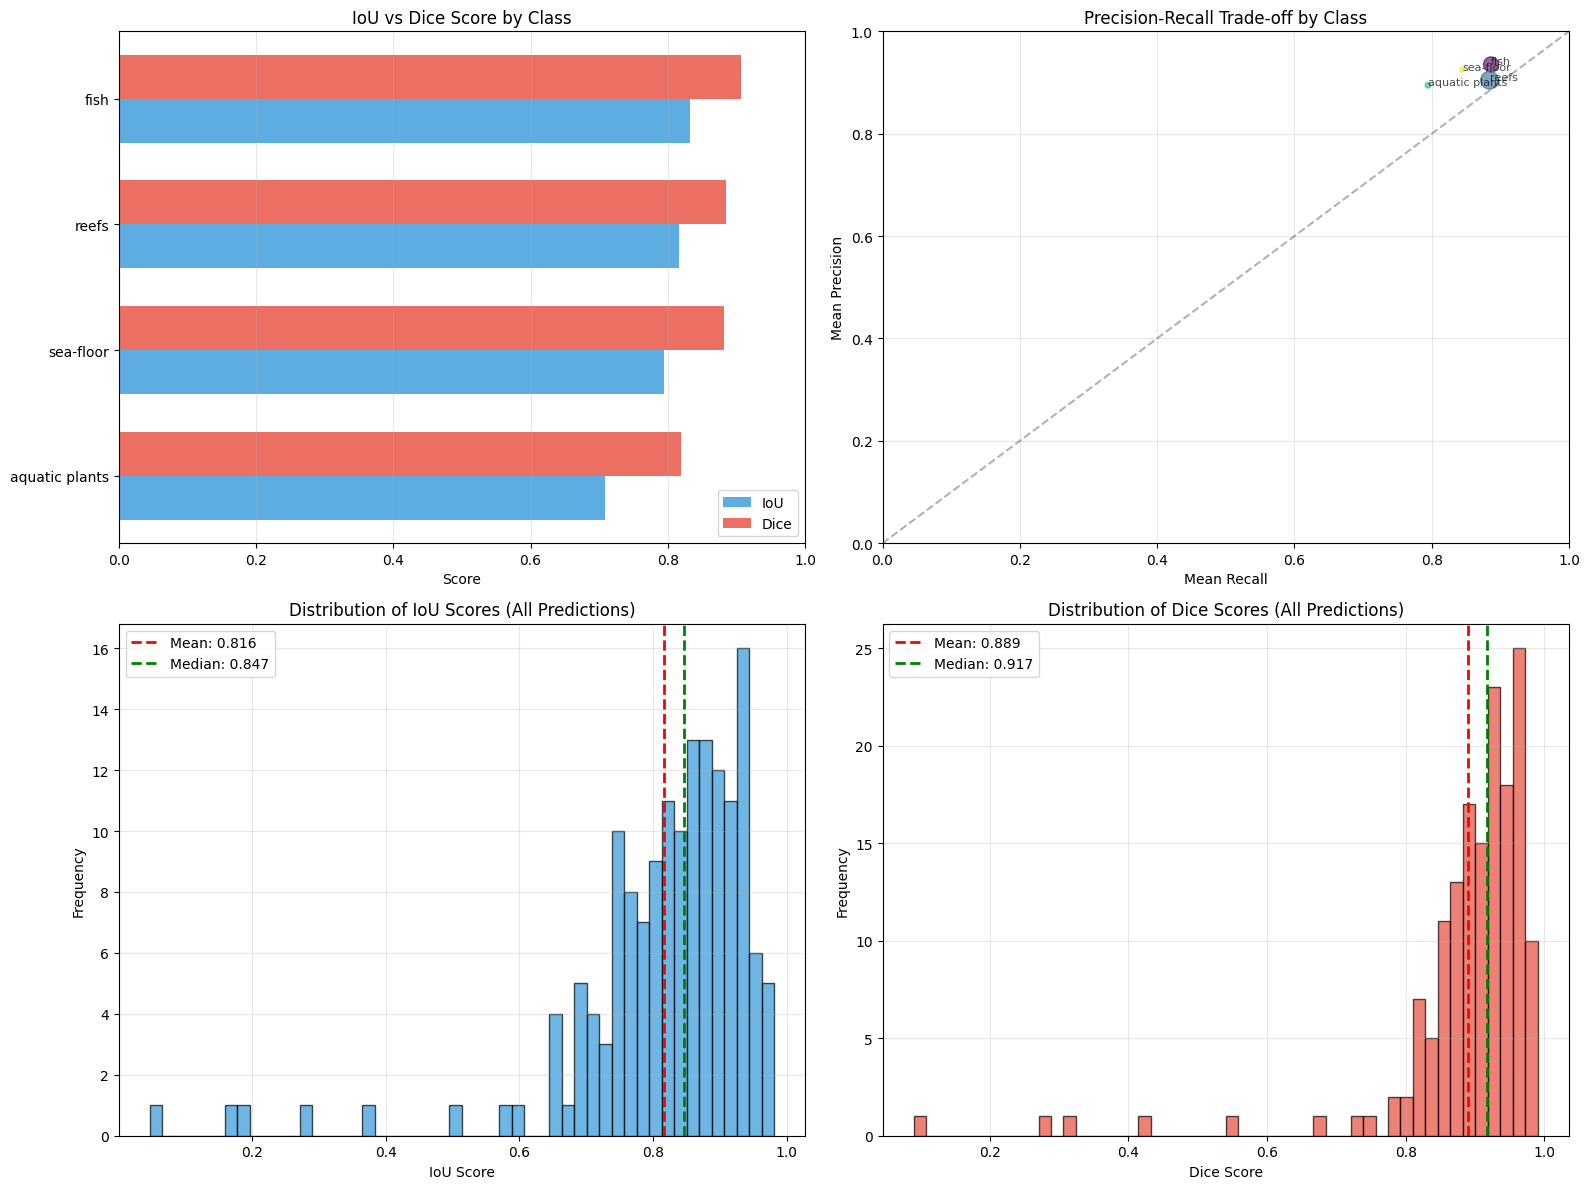

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

stats_sorted = stats_df_box.sort_values('Mean IoU', ascending=True)
x = np.arange(len(stats_sorted))
width = 0.35

axes[0, 0].barh(x - width/2, stats_sorted['Mean IoU'], width, label='IoU', alpha=0.8, color='#3498db')
axes[0, 0].barh(x + width/2, stats_sorted['Mean Dice'], width, label='Dice', alpha=0.8, color='#e74c3c')
axes[0, 0].set_yticks(x)
axes[0, 0].set_yticklabels(stats_sorted['Class'])
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_title('IoU vs Dice Score by Class')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].set_xlim([0, 1])

axes[0, 1].scatter(stats_df_box['Mean Recall'], stats_df_box['Mean Precision'],
                   s=stats_df_box['Count']*2, alpha=0.6, c=range(len(stats_df_box)), cmap='viridis')
for idx, row in stats_df_box.iterrows():
    axes[0, 1].annotate(row['Class'], (row['Mean Recall'], row['Mean Precision']),
                       fontsize=8, alpha=0.7)
axes[0, 1].set_xlabel('Mean Recall')
axes[0, 1].set_ylabel('Mean Precision')
axes[0, 1].set_title('Precision-Recall Trade-off by Class')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])

results_df = pd.DataFrame(all_results_box)
axes[1, 0].hist(results_df['iou'], bins=50, alpha=0.7, color='#3498db', edgecolor='black')
axes[1, 0].axvline(results_df['iou'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {results_df["iou"].mean():.3f}')
axes[1, 0].axvline(results_df['iou'].median(), color='green', linestyle='--',
                   linewidth=2, label=f'Median: {results_df["iou"].median():.3f}')
axes[1, 0].set_xlabel('IoU Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of IoU Scores (All Predictions)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(results_df['dice'], bins=50, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[1, 1].axvline(results_df['dice'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {results_df["dice"].mean():.3f}')
axes[1, 1].axvline(results_df['dice'].median(), color='green', linestyle='--',
                   linewidth=2, label=f'Median: {results_df["dice"].median():.3f}')
axes[1, 1].set_xlabel('Dice Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Dice Scores (All Predictions)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


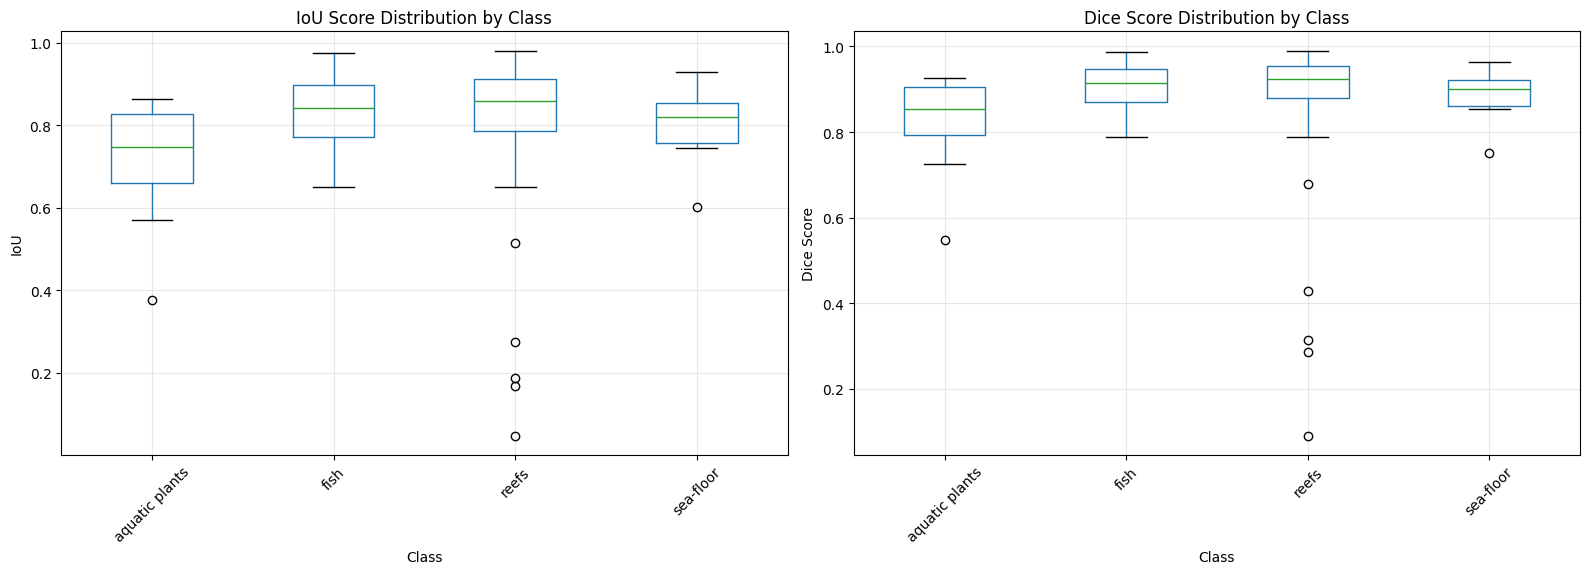

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

results_df.boxplot(column='iou', by='category_name', ax=axes[0], rot=45)
axes[0].set_title('IoU Score Distribution by Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('IoU')
axes[0].get_figure().suptitle('')
axes[0].grid(alpha=0.3)

results_df.boxplot(column='dice', by='category_name', ax=axes[1], rot=45)
axes[1].set_title('Dice Score Distribution by Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Dice Score')
axes[1].get_figure().suptitle('')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('metric_variability.png', dpi=300, bbox_inches='tight')
plt.show()


Generating prediction overlay visualizations...


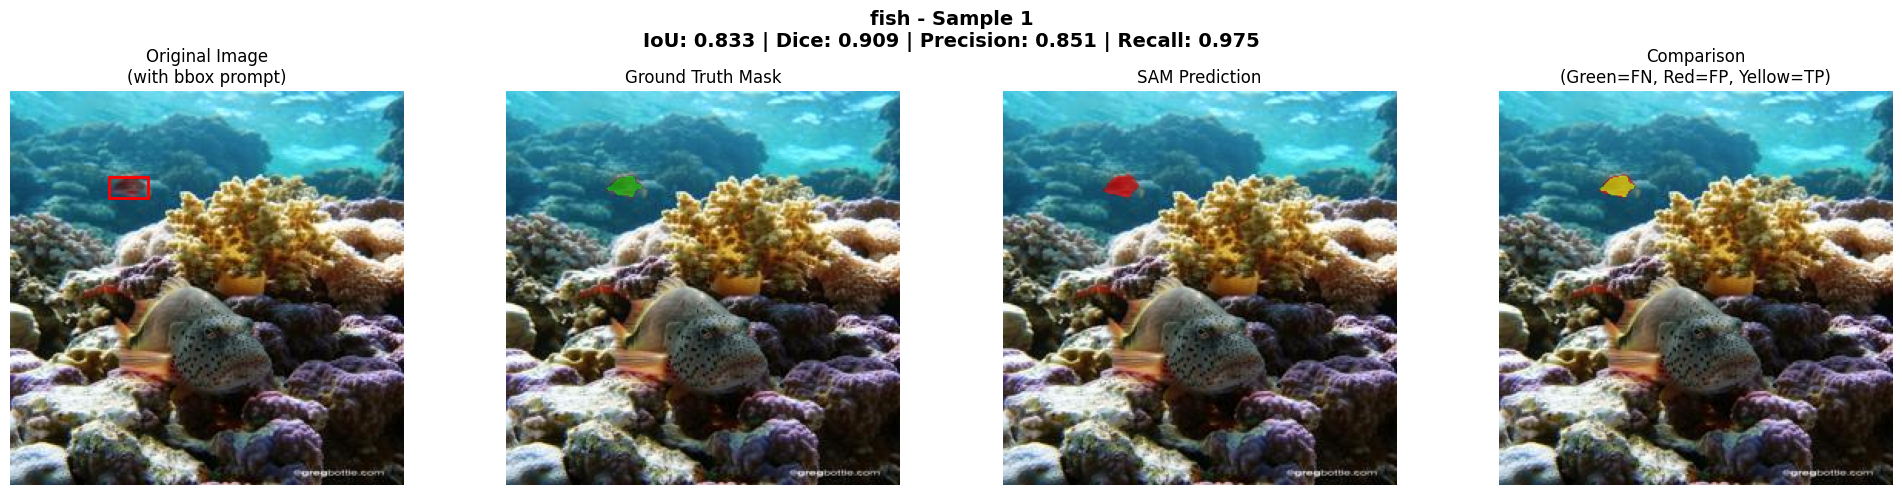

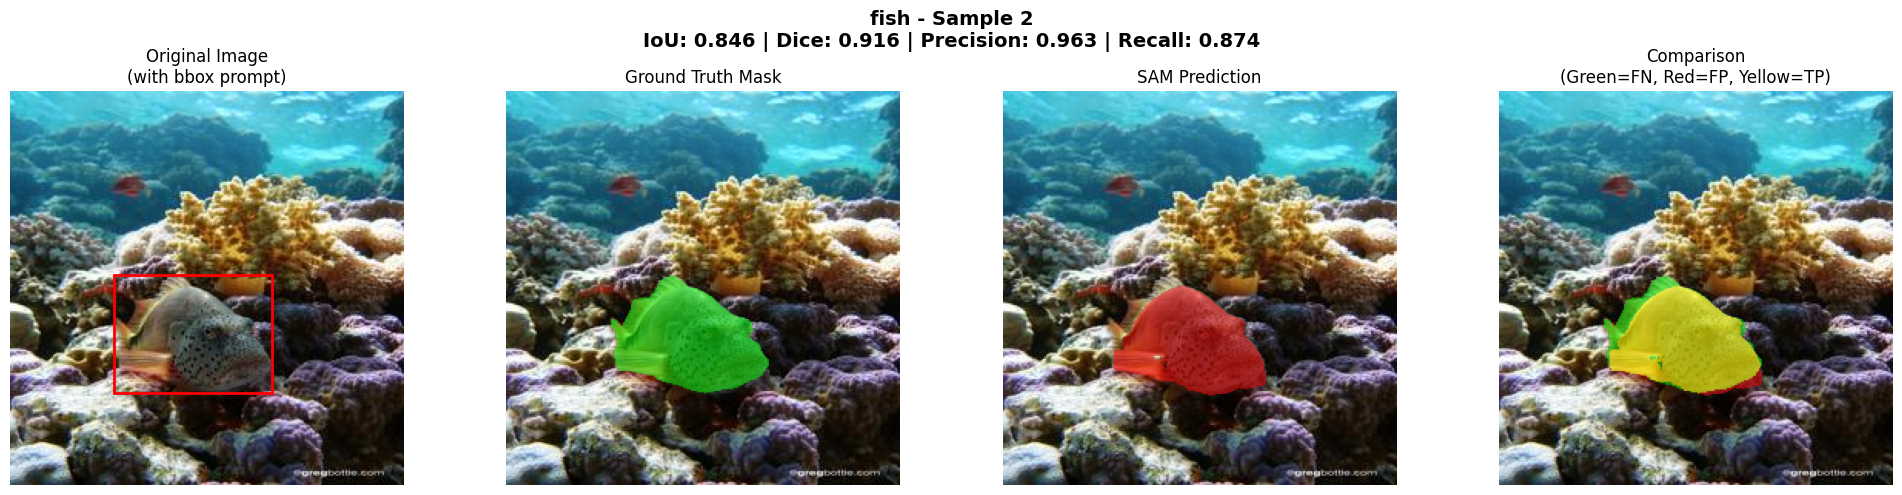

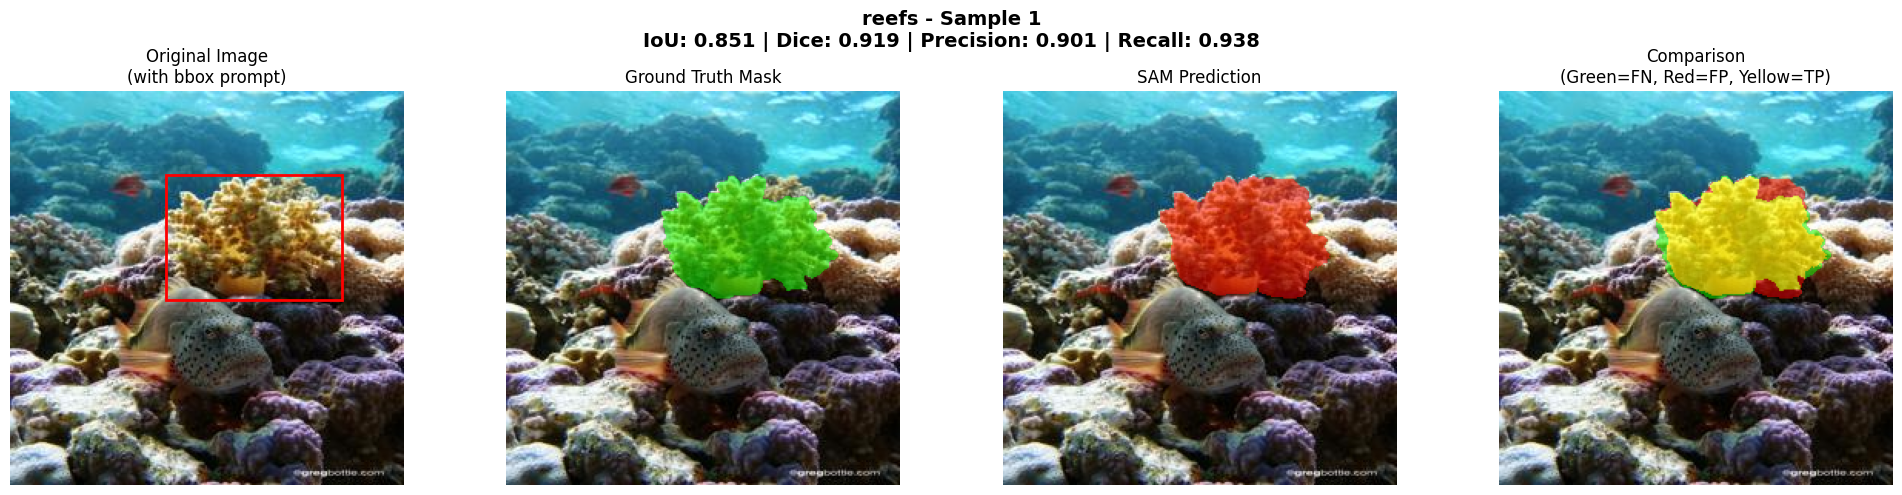

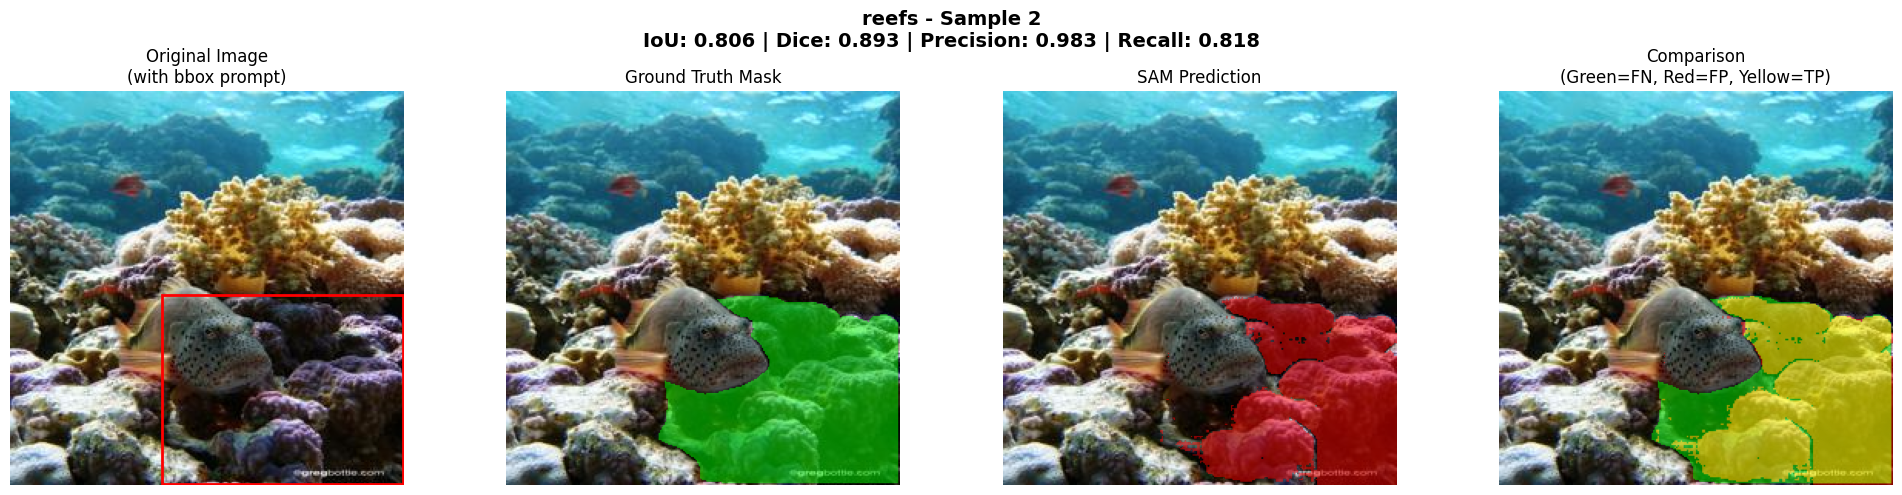

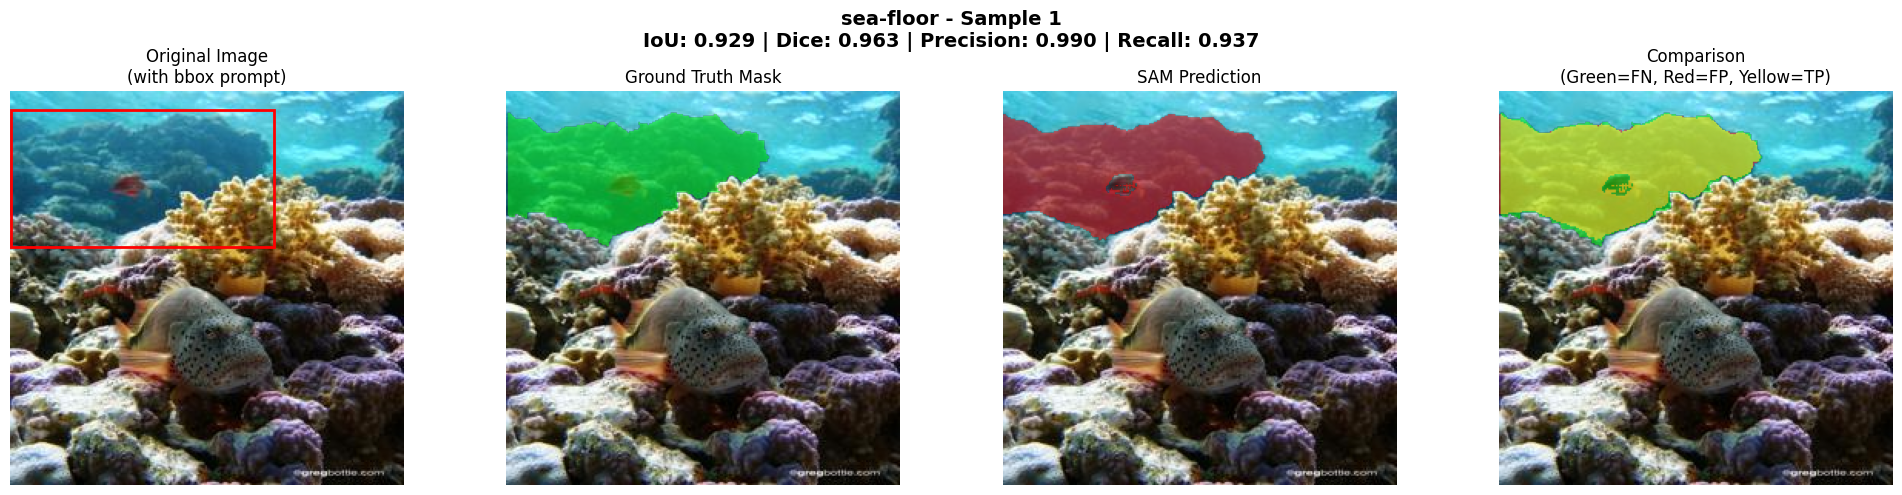

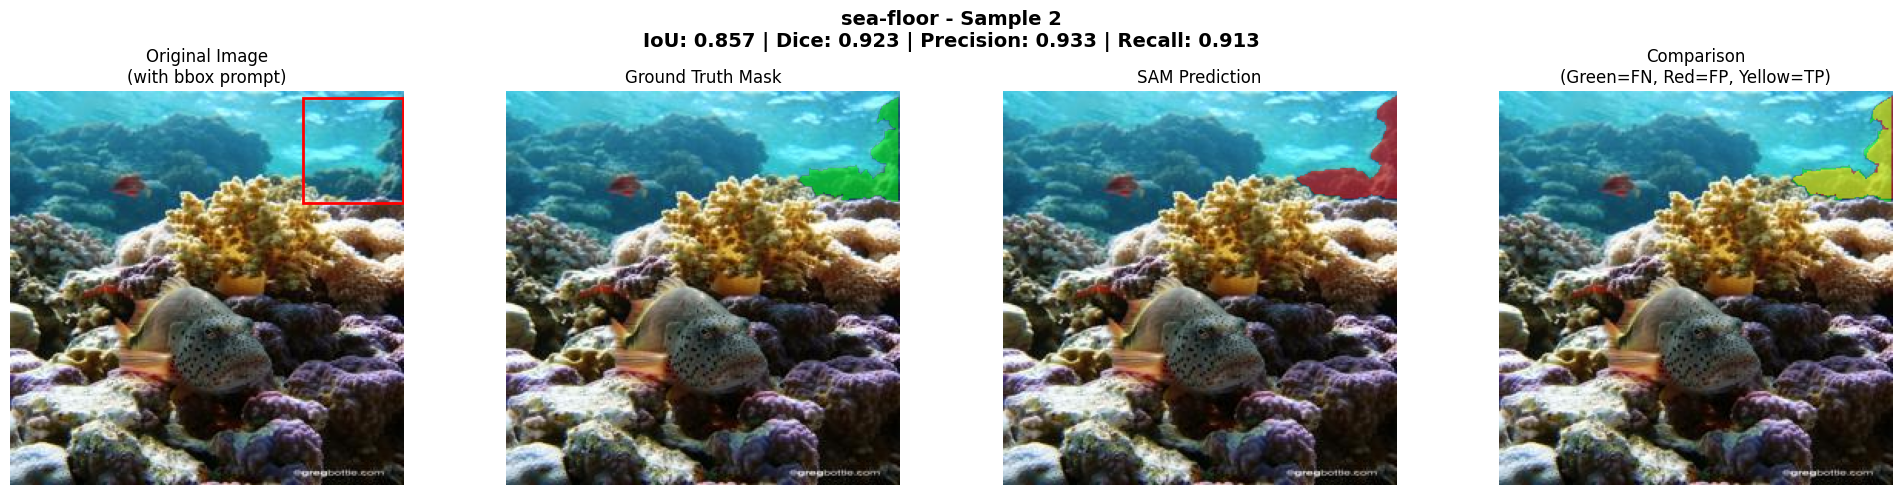

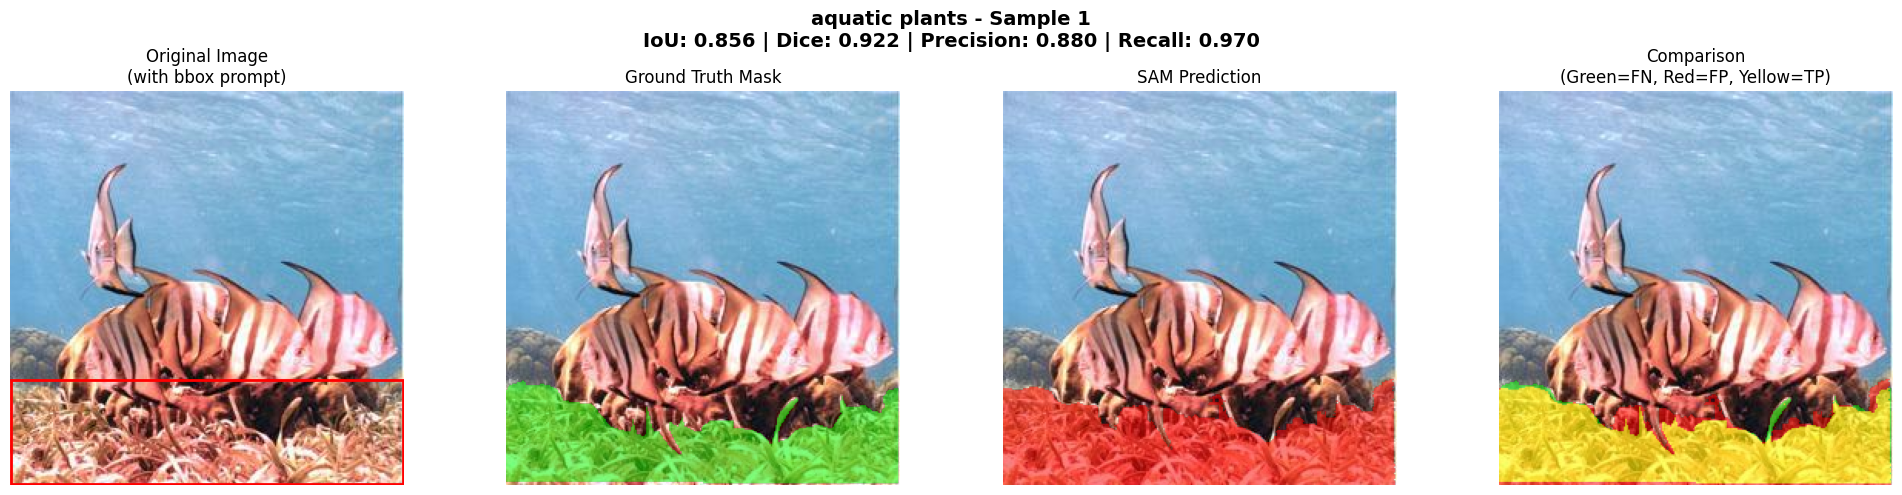

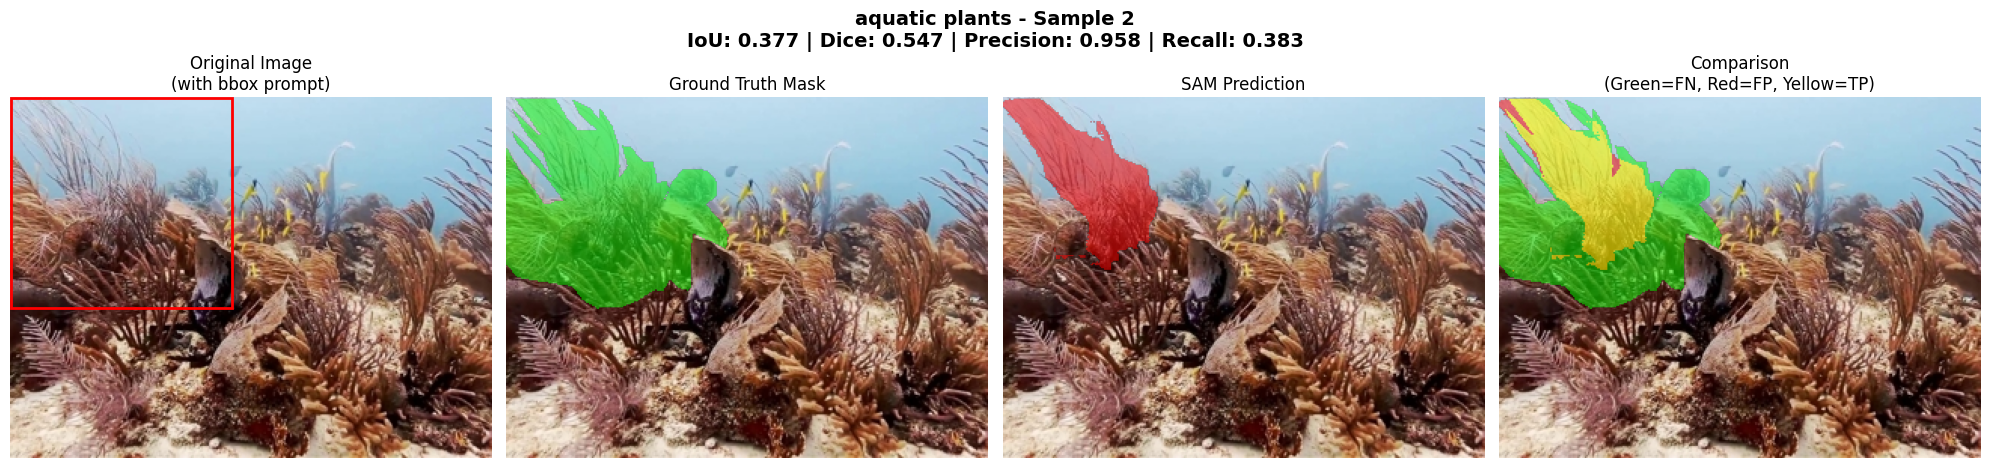

In [ ]:
def visualize_prediction_overlays(samples, num_per_class=3):
    """
    Visualize ground truth and predicted masks overlaid on images
    Shows: Original | GT Overlay | Prediction Overlay | Both Overlays
    """

    samples_by_category = {}
    for sample in samples:
        cat_id = sample['category_id']
        if cat_id not in samples_by_category:
            samples_by_category[cat_id] = []
        if len(samples_by_category[cat_id]) < num_per_class:
            samples_by_category[cat_id].append(sample)

    for cat_id, cat_samples in samples_by_category.items():
        cat_name = cat_samples[0]['category_name']

        for idx, sample in enumerate(cat_samples):
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            image = sample['image']
            gt_mask = sample['gt_mask']
            pred_mask = sample['pred_mask']
            metrics = sample['metrics']
            bbox = sample['bbox']

            axes[0].imshow(image)
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                fill=False, edgecolor='red', linewidth=2)
            axes[0].add_patch(rect)
            axes[0].set_title('Original Image\n(with bbox prompt)')
            axes[0].axis('off')

            axes[1].imshow(image)
            gt_overlay = np.zeros((*gt_mask.shape, 4))
            gt_overlay[gt_mask > 0] = [0, 1, 0, 0.5]
            axes[1].imshow(gt_overlay)
            axes[1].set_title('Ground Truth Mask')
            axes[1].axis('off')

            axes[2].imshow(image)
            pred_overlay = np.zeros((*pred_mask.shape, 4))
            pred_overlay[pred_mask > 0] = [1, 0, 0, 0.5]
            axes[2].imshow(pred_overlay)
            axes[2].set_title('SAM Prediction')
            axes[2].axis('off')

            axes[3].imshow(image)
            combined_overlay = np.zeros((*gt_mask.shape, 4))
            combined_overlay[np.logical_and(gt_mask > 0, pred_mask > 0)] = [1, 1, 0, 0.6]
            combined_overlay[np.logical_and(gt_mask > 0, pred_mask == 0)] = [0, 1, 0, 0.5]
            combined_overlay[np.logical_and(gt_mask == 0, pred_mask > 0)] = [1, 0, 0, 0.5]
            axes[3].imshow(combined_overlay)
            axes[3].set_title('Comparison\n(Green=FN, Red=FP, Yellow=TP)')
            axes[3].axis('off')

            fig.suptitle(
                f'{cat_name} - Sample {idx+1}\n'
                f'IoU: {metrics["iou"]:.3f} | Dice: {metrics["dice"]:.3f} | '
                f'Precision: {metrics["precision"]:.3f} | Recall: {metrics["recall"]:.3f}',
                fontsize=14, fontweight='bold'
            )

            plt.tight_layout()

            plt.show()

print("Generating prediction overlay visualizations...")
visualize_prediction_overlays(samples_box, num_per_class=2)


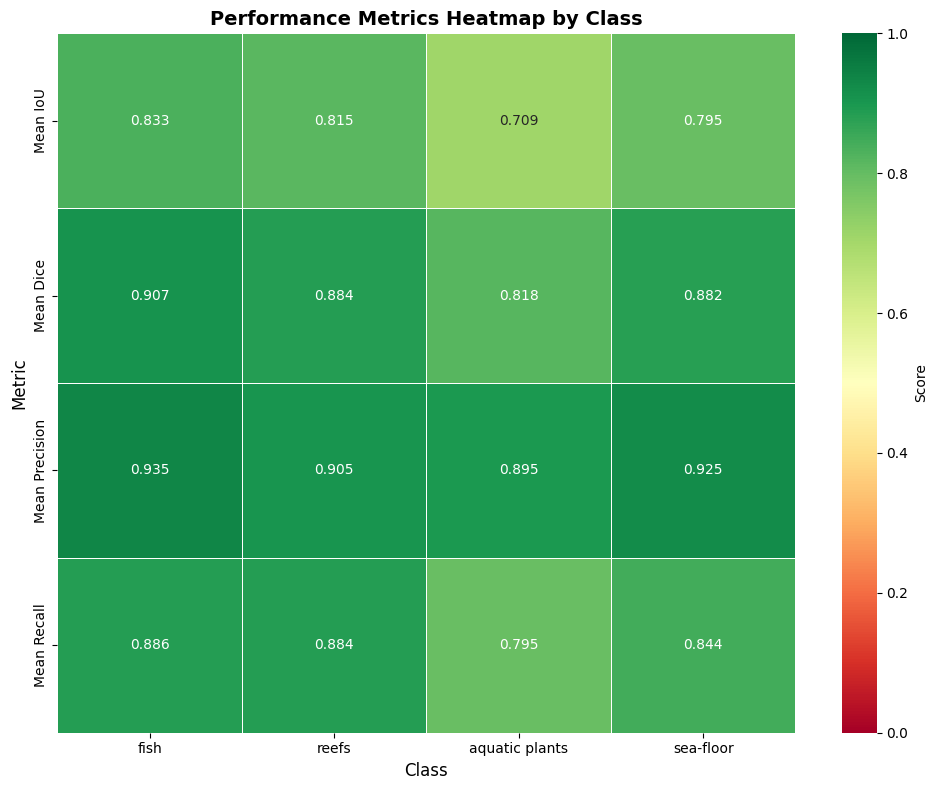

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

metrics_for_heatmap = stats_df_box[['Class', 'Mean IoU', 'Mean Dice',
                                          'Mean Precision', 'Mean Recall']].set_index('Class')

sns.heatmap(metrics_for_heatmap.T, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, cbar_kws={'label': 'Score'}, ax=ax, linewidths=0.5)
ax.set_title('Performance Metrics Heatmap by Class', fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)

plt.tight_layout()
plt.savefig('metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*80)

print(f"\nDataset: UIIS10K Underwater Segmentation")
print(f"Total Images Evaluated: {len(set([r['image_id'] for r in all_results_box]))}")
print(f"Total Annotations: {len(all_results_box)}")
print(f"Classes: {len(stats_df_box)}")

print("\n--- Overall Performance ---")
print(f"Mean IoU: {results_df['iou'].mean():.4f} ± {results_df['iou'].std():.4f}")
print(f"Mean Dice: {results_df['dice'].mean():.4f} ± {results_df['dice'].std():.4f}")
print(f"Mean Precision: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Mean Recall: {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

print("\n--- Best Performing Classes (by IoU) ---")
top_3 = stats_df_box.nlargest(3, 'Mean IoU')
for idx, row in top_3.iterrows():
    print(f"{row['Class']}: IoU={row['Mean IoU']:.4f}, Dice={row['Mean Dice']:.4f}")

print("\n--- Worst Performing Classes (by IoU) ---")
bottom_3 = stats_df_box.nsmallest(3, 'Mean IoU')
for idx, row in bottom_3.iterrows():
    print(f"{row['Class']}: IoU={row['Mean IoU']:.4f}, Dice={row['Mean Dice']:.4f}")

print("\n" + "="*80)

stats_df_box.to_csv('sam_uiis10k_enhanced_statistics.csv', index=False)
results_df.to_csv('sam_uiis10k_detailed_results.csv', index=False)
print("\nResults saved to CSV files!")



COMPREHENSIVE EVALUATION SUMMARY

Dataset: UIIS10K Underwater Segmentation
Total Images Evaluated: 50
Total Annotations: 156
Classes: 4

--- Overall Performance ---
Mean IoU: 0.8159 ± 0.1431
Mean Dice: 0.8895 ± 0.1188
Mean Precision: 0.9167 ± 0.1142
Mean Recall: 0.8790 ± 0.1318

--- Best Performing Classes (by IoU) ---
fish: IoU=0.8328, Dice=0.9066
reefs: IoU=0.8155, Dice=0.8844
sea-floor: IoU=0.7950, Dice=0.8819

--- Worst Performing Classes (by IoU) ---
aquatic plants: IoU=0.7086, Dice=0.8184
sea-floor: IoU=0.7950, Dice=0.8819
reefs: IoU=0.8155, Dice=0.8844


Results saved to CSV files!
